## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [4]:
df_train = pd.read_csv("../../data/train/geno/geno_maccs_train.csv")
df_test = pd.read_csv("../../data/train/geno/geno_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/geno/geno_maccs_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [5]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'genotoxicity']
y_train_all = df_train_all['genotoxicity']

X_train = df_train_all.loc[:, df_train_all.columns != 'genotoxicity']
y_train = df_train_all['genotoxicity']

X_test = df_test.loc[:, df_test.columns != 'genotoxicity']
y_test = df_test['genotoxicity']

X_valid = df_valid.loc[:, df_valid.columns != 'genotoxicity']
y_valid = df_valid['genotoxicity']

In [6]:
X_train.shape

(19931, 166)

In [7]:
X_test.shape

(4984, 166)

In [8]:
X_valid.shape

(2491, 166)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [9]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(166, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [10]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [11]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=2491, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 2.1569867491913453, Accuracy: -9.398076543282997
Test Avg. loss: 0.7700904607772827, Accuracy: -2.2170096130095263
################## EPOCH 2 ##################
Train Avg. loss: 1.624198115943523, Accuracy: -6.965400777505277
Test Avg. loss: 0.4381387233734131, Accuracy: -0.8302997019525005
################## EPOCH 3 ##################
Train Avg. loss: 1.3438012763068534, Accuracy: -5.525416033158195
Test Avg. loss: 0.4375964403152466, Accuracy: -0.8280343200340023
################## EPOCH 4 ##################
Train Avg. loss: 1.136905783826237, Accuracy: -4.512330002664981
Test Avg. loss: 0.5407803058624268, Accuracy: -1.2590792870365988
################## EPOCH 5 ##################
Train Avg. loss: 0.9470890052915576, Accuracy: -3.5691645968179393
Test Avg. loss: 0.4559871554374695, Accuracy: -0.9048607644541338
################## EPOCH 6 ##################
Train Avg. loss: 0.800299838591923

Train Avg. loss: 0.19293801923002898, Accuracy: 0.15262940617630602
Test Avg. loss: 0.15978315472602844, Accuracy: 0.3325148470229222
################## EPOCH 47 ##################
Train Avg. loss: 0.19470096278463284, Accuracy: 0.14905660248929048
Test Avg. loss: 0.16540083289146423, Accuracy: 0.3090473131037691
################## EPOCH 48 ##################
Train Avg. loss: 0.1908842283054397, Accuracy: 0.16647466738040426
Test Avg. loss: 0.15956473350524902, Accuracy: 0.33342734833551824
################## EPOCH 49 ##################
Train Avg. loss: 0.19109521786507405, Accuracy: 0.16137622007138694
Test Avg. loss: 0.15704688429832458, Accuracy: 0.34394543309416326
################## EPOCH 50 ##################
Train Avg. loss: 0.18947895310735435, Accuracy: 0.16916743811763435
Test Avg. loss: 0.15845049917697906, Accuracy: 0.33808197483275526
################## EPOCH 51 ##################
Train Avg. loss: 0.18961919438733718, Accuracy: 0.17449090358783595
Test Avg. loss: 0.1602281

Train Avg. loss: 0.16873964365948452, Accuracy: 0.25186183336107654
Test Avg. loss: 0.13538560271263123, Accuracy: 0.4344342670445791
################## EPOCH 93 ##################
Train Avg. loss: 0.16754700592083685, Accuracy: 0.2539860296408027
Test Avg. loss: 0.13640794157981873, Accuracy: 0.4301635419529999
################## EPOCH 94 ##################
Train Avg. loss: 0.16731080123452083, Accuracy: 0.2556768432527199
Test Avg. loss: 0.14045946300029755, Accuracy: 0.41323850667279605
################## EPOCH 95 ##################
Train Avg. loss: 0.16699443243288498, Accuracy: 0.25735604731482625
Test Avg. loss: 0.13690876960754395, Accuracy: 0.42807136019755965
################## EPOCH 96 ##################
Train Avg. loss: 0.1690435718153013, Accuracy: 0.25065125271236244
Test Avg. loss: 0.13439060747623444, Accuracy: 0.43859082321140597
################## EPOCH 97 ##################
Train Avg. loss: 0.1696551370570499, Accuracy: 0.24962089587765773
Test Avg. loss: 0.1357052326

Train Avg. loss: 0.15362884007382355, Accuracy: 0.3110876373491796
Test Avg. loss: 0.1269952803850174, Accuracy: 0.4694843431304415
################## EPOCH 139 ##################
Train Avg. loss: 0.15549537568184194, Accuracy: 0.30640942411365774
Test Avg. loss: 0.12556599080562592, Accuracy: 0.47545515118578696
################## EPOCH 140 ##################
Train Avg. loss: 0.15531415306928645, Accuracy: 0.30607351426693363
Test Avg. loss: 0.1225413903594017, Accuracy: 0.48809028215072636
################## EPOCH 141 ##################
Train Avg. loss: 0.1523770491680785, Accuracy: 0.3146976180581018
Test Avg. loss: 0.12905697524547577, Accuracy: 0.4608717529522566
################## EPOCH 142 ##################
Train Avg. loss: 0.15718282322080904, Accuracy: 0.2973044519651303
Test Avg. loss: 0.13277487456798553, Accuracy: 0.4453404279893751
################## EPOCH 143 ##################
Train Avg. loss: 0.15452339647286967, Accuracy: 0.31023891856413643
Test Avg. loss: 0.12629847

Train Avg. loss: 0.1489465730997284, Accuracy: 0.3296642096384796
Test Avg. loss: 0.12185356765985489, Accuracy: 0.4909635927393752
################## EPOCH 185 ##################
Train Avg. loss: 0.14672020411964978, Accuracy: 0.34570674097107745
Test Avg. loss: 0.12136624753475189, Accuracy: 0.492999334919325
################## EPOCH 186 ##################
Train Avg. loss: 0.14580067268678887, Accuracy: 0.3426225580020211
Test Avg. loss: 0.12069320678710938, Accuracy: 0.4958109245127138
################## EPOCH 187 ##################
Train Avg. loss: 0.1441014295871434, Accuracy: 0.3499431135123141
Test Avg. loss: 0.1210310086607933, Accuracy: 0.4943997676218054
################## EPOCH 188 ##################
Train Avg. loss: 0.1464930357139432, Accuracy: 0.34146429090665137
Test Avg. loss: 0.12200849503278732, Accuracy: 0.4903163690638709
################## EPOCH 189 ##################
Train Avg. loss: 0.14487856604386104, Accuracy: 0.3461972926716452
Test Avg. loss: 0.1266570389270

Train Avg. loss: 0.14012645082144637, Accuracy: 0.36665357098935
Test Avg. loss: 0.11218640208244324, Accuracy: 0.5313476207205556
################## EPOCH 231 ##################
Train Avg. loss: 0.13981548235131305, Accuracy: 0.36667891582771933
Test Avg. loss: 0.11251039803028107, Accuracy: 0.5299941431626196
################## EPOCH 232 ##################
Train Avg. loss: 0.14052311392025618, Accuracy: 0.36552945281302324
Test Avg. loss: 0.12189017981290817, Accuracy: 0.49081063939410696
################## EPOCH 233 ##################
Train Avg. loss: 0.13910080753207016, Accuracy: 0.3666576927345579
Test Avg. loss: 0.10993392020463943, Accuracy: 0.5407572177617465
################## EPOCH 234 ##################
Train Avg. loss: 0.13952782183263696, Accuracy: 0.36935237504655416
Test Avg. loss: 0.11254268884658813, Accuracy: 0.5298592424495585
################## EPOCH 235 ##################
Train Avg. loss: 0.14119834839747575, Accuracy: 0.36516549493359274
Test Avg. loss: 0.1197621

Train Avg. loss: 0.13445806824400375, Accuracy: 0.3919253056831567
Test Avg. loss: 0.11258959770202637, Accuracy: 0.5296632636916014
################## EPOCH 277 ##################
Train Avg. loss: 0.13404290654351203, Accuracy: 0.3866945854649461
Test Avg. loss: 0.11195492744445801, Accuracy: 0.532314591451815
################## EPOCH 278 ##################
Train Avg. loss: 0.13685771153812232, Accuracy: 0.3807899573675111
Test Avg. loss: 0.11084195226430893, Accuracy: 0.5369639998048027
################## EPOCH 279 ##################
Train Avg. loss: 0.13296470433521423, Accuracy: 0.39696787861605687
Test Avg. loss: 0.10649818927049637, Accuracy: 0.5551098130236325
################## EPOCH 280 ##################
Train Avg. loss: 0.1338416145364029, Accuracy: 0.3889526129606583
Test Avg. loss: 0.10793806612491608, Accuracy: 0.5490948554988433
################## EPOCH 281 ##################
Train Avg. loss: 0.13470711353956982, Accuracy: 0.3875425365494196
Test Avg. loss: 0.11239945143

Train Avg. loss: 0.30728697867538685, Accuracy: -0.3189526839381774
Test Avg. loss: 0.20567740499973297, Accuracy: 0.14079427778932463
################## EPOCH 23 ##################
Train Avg. loss: 0.2916946759065374, Accuracy: -0.24682958586505108
Test Avg. loss: 0.20311033725738525, Accuracy: 0.15151801621590832
################## EPOCH 24 ##################
Train Avg. loss: 0.2822642337817412, Accuracy: -0.2048255582775652
Test Avg. loss: 0.20266976952552795, Accuracy: 0.15335840018174873
################## EPOCH 25 ##################
Train Avg. loss: 0.2693510858867413, Accuracy: -0.14718572902387916
Test Avg. loss: 0.20310258865356445, Accuracy: 0.15155035926575033
################## EPOCH 26 ##################
Train Avg. loss: 0.2557486869299259, Accuracy: -0.08723092048480825
Test Avg. loss: 0.19745919108390808, Accuracy: 0.17512531984064894
################## EPOCH 27 ##################
Train Avg. loss: 0.2493378079902285, Accuracy: -0.06020867433407339
Test Avg. loss: 0.19540

Train Avg. loss: 0.17039589323581028, Accuracy: 0.2729825354613449
Test Avg. loss: 0.13541437685489655, Accuracy: 0.434314061317151
################## EPOCH 69 ##################
Train Avg. loss: 0.17100010762134424, Accuracy: 0.26794299082461775
Test Avg. loss: 0.1341046392917633, Accuracy: 0.4397854205729498
################## EPOCH 70 ##################
Train Avg. loss: 0.17100971366445988, Accuracy: 0.26729023643691785
Test Avg. loss: 0.13593439757823944, Accuracy: 0.43214173011425017
################## EPOCH 71 ##################
Train Avg. loss: 0.16973808376739422, Accuracy: 0.2739020094284854
Test Avg. loss: 0.1316504031419754, Accuracy: 0.45003789470135913
################## EPOCH 72 ##################
Train Avg. loss: 0.1673823623941877, Accuracy: 0.28463797125858237
Test Avg. loss: 0.13573016226291656, Accuracy: 0.43299494902258173
################## EPOCH 73 ##################
Train Avg. loss: 0.1671680876841912, Accuracy: 0.2850720788586833
Test Avg. loss: 0.12955190241336

Train Avg. loss: 0.14763336738523763, Accuracy: 0.3631677803320618
Test Avg. loss: 0.11103557795286179, Accuracy: 0.5361551117415256
################## EPOCH 115 ##################
Train Avg. loss: 0.14942893075446287, Accuracy: 0.35520268049652837
Test Avg. loss: 0.11277283728122711, Accuracy: 0.5288978026863358
################## EPOCH 116 ##################
Train Avg. loss: 0.14944706281694847, Accuracy: 0.3572971233066795
Test Avg. loss: 0.11291783303022385, Accuracy: 0.5282921700366869
################## EPOCH 117 ##################
Train Avg. loss: 0.1493271877272771, Accuracy: 0.35667259221642866
Test Avg. loss: 0.11198054254055023, Accuracy: 0.5322075985274962
################## EPOCH 118 ##################
Train Avg. loss: 0.14625147610711745, Accuracy: 0.3685925282517389
Test Avg. loss: 0.11721503734588623, Accuracy: 0.5103408243060823
################## EPOCH 119 ##################
Train Avg. loss: 0.14693836777065045, Accuracy: 0.3693651055349013
Test Avg. loss: 0.113256022

Train Avg. loss: 0.13577446776131788, Accuracy: 0.413108289550096
Test Avg. loss: 0.10348353534936905, Accuracy: 0.5677033411495831
################## EPOCH 161 ##################
Train Avg. loss: 0.13598299814531437, Accuracy: 0.4133389268736407
Test Avg. loss: 0.10542051494121552, Accuracy: 0.5596117369540341
################## EPOCH 162 ##################
Train Avg. loss: 0.13496271048027736, Accuracy: 0.4160479798721205
Test Avg. loss: 0.1058463305234909, Accuracy: 0.5578329904386403
################## EPOCH 163 ##################
Train Avg. loss: 0.13286861202990016, Accuracy: 0.4231215491000813
Test Avg. loss: 0.10496409982442856, Accuracy: 0.5615183742514442
################## EPOCH 164 ##################
Train Avg. loss: 0.1335591215114945, Accuracy: 0.423480235363447
Test Avg. loss: 0.1029692217707634, Accuracy: 0.5698518907511178
################## EPOCH 165 ##################
Train Avg. loss: 0.13484563735815194, Accuracy: 0.41743571320931355
Test Avg. loss: 0.10243827104568

Train Avg. loss: 0.12494065817923118, Accuracy: 0.45904574476775484
Test Avg. loss: 0.09582763910293579, Accuracy: 0.5996854543363412
################## EPOCH 207 ##################
Train Avg. loss: 0.127231908400949, Accuracy: 0.44515352073328973
Test Avg. loss: 0.09475939720869064, Accuracy: 0.6041479654249853
################## EPOCH 208 ##################
Train Avg. loss: 0.12665395922242448, Accuracy: 0.45262413551561803
Test Avg. loss: 0.09569383412599564, Accuracy: 0.6002443999830589
################## EPOCH 209 ##################
Train Avg. loss: 0.12520031063841322, Accuracy: 0.455585016838036
Test Avg. loss: 0.09364732354879379, Accuracy: 0.6087935853863764
################## EPOCH 210 ##################
Train Avg. loss: 0.1259418424600974, Accuracy: 0.45318380325368096
Test Avg. loss: 0.09897314757108688, Accuracy: 0.5865452838167464
################## EPOCH 211 ##################
Train Avg. loss: 0.1249742089675214, Accuracy: 0.45479043321581814
Test Avg. loss: 0.0969525054

Train Avg. loss: 0.11956529725247468, Accuracy: 0.47850339420783683
Test Avg. loss: 0.09193908423185349, Accuracy: 0.6159296597447605
################## EPOCH 253 ##################
Train Avg. loss: 0.11834414206588498, Accuracy: 0.4828667608599852
Test Avg. loss: 0.09324943274259567, Accuracy: 0.6104557135953195
################## EPOCH 254 ##################
Train Avg. loss: 0.12101470283829631, Accuracy: 0.47515143511899155
Test Avg. loss: 0.0921458825469017, Accuracy: 0.6150657742600237
################## EPOCH 255 ##################
Train Avg. loss: 0.11743777673930311, Accuracy: 0.48725824550520186
Test Avg. loss: 0.0930769219994545, Accuracy: 0.6111764144570837
################## EPOCH 256 ##################
Train Avg. loss: 0.11912270950583312, Accuracy: 0.4817460209268256
Test Avg. loss: 0.09201396256685257, Accuracy: 0.6156168553614992
################## EPOCH 257 ##################
Train Avg. loss: 0.11867317236148012, Accuracy: 0.4836467906358297
Test Avg. loss: 0.092625699

Train Avg. loss: 0.11446614109743865, Accuracy: 0.5036371874390677
Test Avg. loss: 0.09010840952396393, Accuracy: 0.6235771943028755
################## EPOCH 299 ##################
Train Avg. loss: 0.11550744521455505, Accuracy: 0.497327582430967
Test Avg. loss: 0.0863473042845726, Accuracy: 0.6392889754712056
################## EPOCH 300 ##################
Train Avg. loss: 0.11147593015518326, Accuracy: 0.5107461875851573
Test Avg. loss: 0.08901679515838623, Accuracy: 0.6281373326960153
Model: lr 0.001, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 2.3748524578718038, Accuracy: -9.013814279297835
Test Avg. loss: 0.6802938580513, Accuracy: -1.8418894032639677
################## EPOCH 2 ##################
Train Avg. loss: 1.5400546762423637, Accuracy: -5.644514872157828
Test Avg. loss: 0.43833139538764954, Accuracy: -0.8311047610030105
################## EPOCH 3 ##################
Train Avg. loss: 1.5311221442161462, Accuracy: -5.617699455918065
Test Avg.

Train Avg. loss: 0.26097783790184903, Accuracy: -0.09907273304631904
Test Avg. loss: 0.18325777351856232, Accuracy: 0.23445095384356962
################## EPOCH 45 ##################
Train Avg. loss: 0.2562679223334178, Accuracy: -0.07497898399079268
Test Avg. loss: 0.1817229986190796, Accuracy: 0.24086240652692814
################## EPOCH 46 ##################
Train Avg. loss: 0.2497807339980052, Accuracy: -0.04696207497317652
Test Avg. loss: 0.1805863380432129, Accuracy: 0.2456107871079295
################## EPOCH 47 ##################
Train Avg. loss: 0.24105828971816942, Accuracy: -0.011274311242687697
Test Avg. loss: 0.17554259300231934, Accuracy: 0.26668071771133794
################## EPOCH 48 ##################
Train Avg. loss: 0.2370695634625661, Accuracy: 0.0070670593236054026
Test Avg. loss: 0.17414432764053345, Accuracy: 0.27252189523602877
################## EPOCH 49 ##################
Train Avg. loss: 0.2307605283955733, Accuracy: 0.034124807124530476
Test Avg. loss: 0.176

Train Avg. loss: 0.16412642531287977, Accuracy: 0.30912119591651377
Test Avg. loss: 0.1254071742296219, Accuracy: 0.47611858291942033
################## EPOCH 91 ##################
Train Avg. loss: 0.16284605402212876, Accuracy: 0.3141960621098884
Test Avg. loss: 0.12120097130537033, Accuracy: 0.49368978620945525
################## EPOCH 92 ##################
Train Avg. loss: 0.1608814303882611, Accuracy: 0.32344020541593094
Test Avg. loss: 0.12070310860872269, Accuracy: 0.4957695379621637
################## EPOCH 93 ##################
Train Avg. loss: 0.16228691722529057, Accuracy: 0.31753129704834193
Test Avg. loss: 0.11998619884252548, Accuracy: 0.4987644325811872
################## EPOCH 94 ##################
Train Avg. loss: 0.16192997939502582, Accuracy: 0.3199669646777672
Test Avg. loss: 0.12130429595708847, Accuracy: 0.49325811144750464
################## EPOCH 95 ##################
Train Avg. loss: 0.15876833139321742, Accuracy: 0.3331503008080043
Test Avg. loss: 0.11894592642

Train Avg. loss: 0.14183447777460784, Accuracy: 0.4006465594655194
Test Avg. loss: 0.10293859243392944, Accuracy: 0.5699798163271669
################## EPOCH 137 ##################
Train Avg. loss: 0.14192487256458172, Accuracy: 0.4003001574153974
Test Avg. loss: 0.10464044660329819, Accuracy: 0.5628704364832646
################## EPOCH 138 ##################
Train Avg. loss: 0.14047577404058897, Accuracy: 0.4072301824558244
Test Avg. loss: 0.10277484357357025, Accuracy: 0.57066384437506
################## EPOCH 139 ##################
Train Avg. loss: 0.13993905136027399, Accuracy: 0.409563335394614
Test Avg. loss: 0.10360246151685715, Accuracy: 0.5672065249994186
################## EPOCH 140 ##################
Train Avg. loss: 0.14297004024951887, Accuracy: 0.3980595332047635
Test Avg. loss: 0.10205759108066559, Accuracy: 0.573660139818596
################## EPOCH 141 ##################
Train Avg. loss: 0.13741783764308843, Accuracy: 0.4182505567573314
Test Avg. loss: 0.10385821759700

Train Avg. loss: 0.1305798576810421, Accuracy: 0.44826542047998164
Test Avg. loss: 0.09672264754772186, Accuracy: 0.5959466063744643
################## EPOCH 183 ##################
Train Avg. loss: 0.13040821908567196, Accuracy: 0.4492679097836219
Test Avg. loss: 0.0965089201927185, Accuracy: 0.5968394172568043
################## EPOCH 184 ##################
Train Avg. loss: 0.12887572482801402, Accuracy: 0.4543114347331289
Test Avg. loss: 0.09334632754325867, Accuracy: 0.6100509578973071
################## EPOCH 185 ##################
Train Avg. loss: 0.13056306794094732, Accuracy: 0.44644593880549605
Test Avg. loss: 0.09656397998332977, Accuracy: 0.5966094194371926
################## EPOCH 186 ##################
Train Avg. loss: 0.12980438582599163, Accuracy: 0.44949602931095145
Test Avg. loss: 0.0960240438580513, Accuracy: 0.5988649744675048
################## EPOCH 187 ##################
Train Avg. loss: 0.1295890058271396, Accuracy: 0.45073367307936313
Test Avg. loss: 0.0949594900

Train Avg. loss: 0.12122447521258624, Accuracy: 0.48396937655469774
Test Avg. loss: 0.09528390318155289, Accuracy: 0.6019568702236509
################## EPOCH 229 ##################
Train Avg. loss: 0.12092631133512044, Accuracy: 0.48574258289457634
Test Avg. loss: 0.09452930837869644, Accuracy: 0.6051091686049712
################## EPOCH 230 ##################
Train Avg. loss: 0.12392224075320439, Accuracy: 0.4748026825883862
Test Avg. loss: 0.09340590238571167, Accuracy: 0.6098021116156811
################## EPOCH 231 ##################
Train Avg. loss: 0.12122746322972652, Accuracy: 0.4840644171351401
Test Avg. loss: 0.09044481068849564, Accuracy: 0.6221718572397548
################## EPOCH 232 ##################
Train Avg. loss: 0.12062156644578163, Accuracy: 0.4882333397603064
Test Avg. loss: 0.0909116193652153, Accuracy: 0.6202218402711654
################## EPOCH 233 ##################
Train Avg. loss: 0.12078354154259731, Accuracy: 0.4877467993992259
Test Avg. loss: 0.094558931

Train Avg. loss: 0.1185662744519038, Accuracy: 0.4969027189946907
Test Avg. loss: 0.08764725178480148, Accuracy: 0.6338585387738137
################## EPOCH 275 ##################
Train Avg. loss: 0.11494885203547967, Accuracy: 0.5112265957736225
Test Avg. loss: 0.08632061630487442, Accuracy: 0.6394004796354673
################## EPOCH 276 ##################
Train Avg. loss: 0.11684700856224084, Accuracy: 0.5050530462968533
Test Avg. loss: 0.09216960519552231, Accuracy: 0.614966690343032
################## EPOCH 277 ##################
Train Avg. loss: 0.11736985195714694, Accuracy: 0.5023590193330587
Test Avg. loss: 0.09159200638532639, Accuracy: 0.6173795538705867
################## EPOCH 278 ##################
Train Avg. loss: 0.11708638291710462, Accuracy: 0.5008153094266862
Test Avg. loss: 0.08947283029556274, Accuracy: 0.6262322839731573
################## EPOCH 279 ##################
Train Avg. loss: 0.11523964695441417, Accuracy: 0.5098270134301275
Test Avg. loss: 0.087447196245

Train Avg. loss: 1.0172781302378728, Accuracy: -3.2824206775036466
Test Avg. loss: 0.9643594026565552, Accuracy: -3.0285567045553945
################## EPOCH 21 ##################
Train Avg. loss: 1.0137326893133995, Accuracy: -3.2695145291938905
Test Avg. loss: 0.7682029604911804, Accuracy: -2.209124629418124
################## EPOCH 22 ##################
Train Avg. loss: 0.9647897267952944, Accuracy: -3.0528642799010184
Test Avg. loss: 1.146272897720337, Accuracy: -3.7884906297702585
################## EPOCH 23 ##################
Train Avg. loss: 0.9512557402635232, Accuracy: -3.0048519783483436
Test Avg. loss: 1.1408379077911377, Accuracy: -3.765786424976878
################## EPOCH 24 ##################
Train Avg. loss: 0.9423777965398935, Accuracy: -2.9754772937406275
Test Avg. loss: 1.0182862281799316, Accuracy: -3.2538334247644487
################## EPOCH 25 ##################
Train Avg. loss: 0.9081288706033658, Accuracy: -2.81097396145695
Test Avg. loss: 0.7933960556983948, Ac

Train Avg. loss: 0.34831699079427964, Accuracy: -0.4556587263796909
Test Avg. loss: 0.2003559023141861, Accuracy: 0.16302459175951134
################## EPOCH 67 ##################
Train Avg. loss: 0.3399789260748105, Accuracy: -0.4221139449568173
Test Avg. loss: 0.20458415150642395, Accuracy: 0.14536123356058805
################## EPOCH 68 ##################
Train Avg. loss: 0.33232282254940426, Accuracy: -0.38940250351468125
Test Avg. loss: 0.2080974131822586, Accuracy: 0.13068478243426007
################## EPOCH 69 ##################
Train Avg. loss: 0.3277958025917029, Accuracy: -0.3704457824702992
Test Avg. loss: 0.1914169192314148, Accuracy: 0.20036660896640024
################## EPOCH 70 ##################
Train Avg. loss: 0.316213132479252, Accuracy: -0.32027942994391706
Test Avg. loss: 0.18381020426750183, Accuracy: 0.23214321998360732
################## EPOCH 71 ##################
Train Avg. loss: 0.31323983787726134, Accuracy: -0.30747745807344234
Test Avg. loss: 0.17699082

Train Avg. loss: 0.1644615821349315, Accuracy: 0.31595121724064273
Test Avg. loss: 0.12184513360261917, Accuracy: 0.4909988179293465
################## EPOCH 113 ##################
Train Avg. loss: 0.1623511253259121, Accuracy: 0.3232216395459042
Test Avg. loss: 0.11733049154281616, Accuracy: 0.5098584533006543
################## EPOCH 114 ##################
Train Avg. loss: 0.1586304029975182, Accuracy: 0.3379058648219297
Test Avg. loss: 0.11612790822982788, Accuracy: 0.5148821832172354
################## EPOCH 115 ##################
Train Avg. loss: 0.15683807489963678, Accuracy: 0.3472124496756214
Test Avg. loss: 0.11705777049064636, Accuracy: 0.5109977617466704
################## EPOCH 116 ##################
Train Avg. loss: 0.1573221077903723, Accuracy: 0.34419229673386753
Test Avg. loss: 0.11468064785003662, Accuracy: 0.5209280907964494
################## EPOCH 117 ##################
Train Avg. loss: 0.15837287301054367, Accuracy: 0.3423124817854088
Test Avg. loss: 0.114776067435

Train Avg. loss: 0.13782894716430932, Accuracy: 0.42556301235739386
Test Avg. loss: 0.09390243142843246, Accuracy: 0.6077278885204289
################## EPOCH 159 ##################
Train Avg. loss: 0.13521973855602434, Accuracy: 0.43635203222760466
Test Avg. loss: 0.09437944740056992, Accuracy: 0.6057351563574086
################## EPOCH 160 ##################
Train Avg. loss: 0.13464097392100555, Accuracy: 0.4389767337682851
Test Avg. loss: 0.093865305185318, Accuracy: 0.6078829718647539
################## EPOCH 161 ##################
Train Avg. loss: 0.13493806056869337, Accuracy: 0.43912525455030516
Test Avg. loss: 0.09254088252782822, Accuracy: 0.6134156705663292
################## EPOCH 162 ##################
Train Avg. loss: 0.13628515543845984, Accuracy: 0.4328048832861847
Test Avg. loss: 0.09503591805696487, Accuracy: 0.6029928253984844
################## EPOCH 163 ##################
Train Avg. loss: 0.13432752742217138, Accuracy: 0.44010422949113337
Test Avg. loss: 0.09410741

Train Avg. loss: 0.12240330110757779, Accuracy: 0.4884695191470081
Test Avg. loss: 0.08411642909049988, Accuracy: 0.6486083434856649
################## EPOCH 205 ##################
Train Avg. loss: 0.12565798130937111, Accuracy: 0.4776797606795883
Test Avg. loss: 0.08161920309066772, Accuracy: 0.6590403771969751
################## EPOCH 206 ##################
Train Avg. loss: 0.12510625769694647, Accuracy: 0.4780632795450357
Test Avg. loss: 0.0827970951795578, Accuracy: 0.6541198310613456
################## EPOCH 207 ##################
Train Avg. loss: 0.1249584110501485, Accuracy: 0.4803773406597544
Test Avg. loss: 0.08007162809371948, Accuracy: 0.6655052790312619
################## EPOCH 208 ##################
Train Avg. loss: 0.12204014452604148, Accuracy: 0.49163558961870124
Test Avg. loss: 0.08050449192523956, Accuracy: 0.6636970319675479
################## EPOCH 209 ##################
Train Avg. loss: 0.12031759445865949, Accuracy: 0.49649982299456735
Test Avg. loss: 0.0822218731

Train Avg. loss: 0.11570120717470463, Accuracy: 0.5163343731483491
Test Avg. loss: 0.07746144384145737, Accuracy: 0.6764091779393846
################## EPOCH 251 ##################
Train Avg. loss: 0.11660367890428273, Accuracy: 0.5129917733428372
Test Avg. loss: 0.07565069943666458, Accuracy: 0.6839734810861049
################## EPOCH 252 ##################
Train Avg. loss: 0.11711524102168205, Accuracy: 0.5114006201629437
Test Avg. loss: 0.07422629743814468, Accuracy: 0.6899238280993151
################## EPOCH 253 ##################
Train Avg. loss: 0.11702376861984913, Accuracy: 0.5109233001300192
Test Avg. loss: 0.07590634375810623, Accuracy: 0.6829055352538301
################## EPOCH 254 ##################
Train Avg. loss: 0.11586834576267463, Accuracy: 0.5160348550432213
Test Avg. loss: 0.07475747168064117, Accuracy: 0.6877048559235042
################## EPOCH 255 ##################
Train Avg. loss: 0.11638374492908135, Accuracy: 0.5125431921291785
Test Avg. loss: 0.0757540464

Train Avg. loss: 0.11144574970389023, Accuracy: 0.5352608424674755
Test Avg. loss: 0.07229826599359512, Accuracy: 0.6979780703983135
################## EPOCH 297 ##################
Train Avg. loss: 0.11021597072100028, Accuracy: 0.5392914376822006
Test Avg. loss: 0.07506871223449707, Accuracy: 0.6864046810755008
################## EPOCH 298 ##################
Train Avg. loss: 0.10980688809202267, Accuracy: 0.5417308949784823
Test Avg. loss: 0.06979034096002579, Accuracy: 0.7084547648236912
################## EPOCH 299 ##################
Train Avg. loss: 0.11075623295246026, Accuracy: 0.5370137834682298
Test Avg. loss: 0.07156635075807571, Accuracy: 0.7010355838122657
################## EPOCH 300 ##################
Train Avg. loss: 0.10926814167163311, Accuracy: 0.5430536007103886
Test Avg. loss: 0.07137841731309891, Accuracy: 0.7018206921706609
Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 1.9793717208681674, Accuracy: -8.492136642849115


Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 42 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 43 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 44 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 45 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 46 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. l

Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 87 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 88 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 89 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 90 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 91 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. l

Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 132 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 133 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 134 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 135 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 136 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test A

Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 177 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 178 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 179 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 180 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 181 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test A

Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 222 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 223 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 224 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 225 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 226 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test A

Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 267 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 268 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 269 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 270 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test Avg. loss: 0.239473357796669, Accuracy: -0.0003864127810051521
################## EPOCH 271 ##################
Train Avg. loss: 0.24287717065880043, Accuracy: -0.03671201922353159
Test A

Train Avg. loss: 0.23124611329955932, Accuracy: 0.029651458357104872
Test Avg. loss: 0.21314150094985962, Accuracy: 0.10961337312896124
################## EPOCH 12 ##################
Train Avg. loss: 0.22803445205761072, Accuracy: 0.044072959047310865
Test Avg. loss: 0.2137088030576706, Accuracy: 0.10724344898115179
################## EPOCH 13 ##################
Train Avg. loss: 0.22506341049208856, Accuracy: 0.0540492616936771
Test Avg. loss: 0.21649862825870514, Accuracy: 0.09558916651469129
################## EPOCH 14 ##################
Train Avg. loss: 0.224897096100717, Accuracy: 0.055237752021021644
Test Avg. loss: 0.2056954801082611, Accuracy: 0.1407187514019509
################## EPOCH 15 ##################
Train Avg. loss: 0.22548027023768577, Accuracy: 0.0530436326346206
Test Avg. loss: 0.20581652224063873, Accuracy: 0.14021305996390843
################## EPOCH 16 ##################
Train Avg. loss: 0.22535895840384257, Accuracy: 0.05245212740809272
Test Avg. loss: 0.20771731

Train Avg. loss: 0.22147943905721873, Accuracy: 0.07013425918058964
Test Avg. loss: 0.2061486542224884, Accuracy: 0.1388255653785373
################## EPOCH 58 ##################
Train Avg. loss: 0.21906821226748902, Accuracy: 0.07811693737186344
Test Avg. loss: 0.19675196707248688, Accuracy: 0.17807972627349755
################## EPOCH 59 ##################
Train Avg. loss: 0.21656320907939702, Accuracy: 0.08985399312296842
Test Avg. loss: 0.1992064267396927, Accuracy: 0.1678263263675831
################## EPOCH 60 ##################
Train Avg. loss: 0.21802268093690658, Accuracy: 0.08040042436562396
Test Avg. loss: 0.19536226987838745, Accuracy: 0.18388509828252975
################## EPOCH 61 ##################
Train Avg. loss: 0.21693697022512937, Accuracy: 0.08683161453059135
Test Avg. loss: 0.20160049200057983, Accuracy: 0.15782532747122546
################## EPOCH 62 ##################
Train Avg. loss: 0.21966704721443164, Accuracy: 0.07547029304333892
Test Avg. loss: 0.19895343

Train Avg. loss: 0.20890279670651907, Accuracy: 0.12050463436633152
Test Avg. loss: 0.1877923607826233, Accuracy: 0.21550803983437739
################## EPOCH 104 ##################
Train Avg. loss: 0.20684866499728882, Accuracy: 0.1264308164787608
Test Avg. loss: 0.18244291841983795, Accuracy: 0.23785495277106283
################## EPOCH 105 ##################
Train Avg. loss: 0.20859902299558505, Accuracy: 0.1211162864176668
Test Avg. loss: 0.180659681558609, Accuracy: 0.24530433307657118
################## EPOCH 106 ##################
Train Avg. loss: 0.20999442891050607, Accuracy: 0.11385224783031145
Test Avg. loss: 0.18151167035102844, Accuracy: 0.24174520654333165
################## EPOCH 107 ##################
Train Avg. loss: 0.20883319481538656, Accuracy: 0.1186293930265181
Test Avg. loss: 0.18823756277561188, Accuracy: 0.21364812615183804
################## EPOCH 108 ##################
Train Avg. loss: 0.21114040982837862, Accuracy: 0.11115269557107588
Test Avg. loss: 0.19021

Train Avg. loss: 0.20763222178300986, Accuracy: 0.126060495199773
Test Avg. loss: 0.17814458906650543, Accuracy: 0.2558109848644391
################## EPOCH 150 ##################
Train Avg. loss: 0.20386564208624455, Accuracy: 0.1362454158921292
Test Avg. loss: 0.17903941869735718, Accuracy: 0.2520729471951816
################## EPOCH 151 ##################
Train Avg. loss: 0.2056518897939569, Accuracy: 0.13420713319782157
Test Avg. loss: 0.1792968511581421, Accuracy: 0.2509974476558714
################## EPOCH 152 ##################
Train Avg. loss: 0.20303927794194374, Accuracy: 0.1418222974110756
Test Avg. loss: 0.1762477308511734, Accuracy: 0.26373502386535685
################## EPOCH 153 ##################
Train Avg. loss: 0.2037497827401146, Accuracy: 0.1402365385807565
Test Avg. loss: 0.17857876420021057, Accuracy: 0.25399724749228425
################## EPOCH 154 ##################
Train Avg. loss: 0.2060534360173803, Accuracy: 0.12911999802025959
Test Avg. loss: 0.177530169486

Train Avg. loss: 0.2015681053774479, Accuracy: 0.15003615806588183
Test Avg. loss: 0.17480219900608063, Accuracy: 0.2697736710811194
################## EPOCH 196 ##################
Train Avg. loss: 0.20122331481140393, Accuracy: 0.14879450763396546
Test Avg. loss: 0.1803937554359436, Accuracy: 0.24641528241143262
################## EPOCH 197 ##################
Train Avg. loss: 0.2025256468795049, Accuracy: 0.14646739116627167
Test Avg. loss: 0.17666518688201904, Accuracy: 0.2619911697299604
################## EPOCH 198 ##################
Train Avg. loss: 0.20316092882496425, Accuracy: 0.14018246764951836
Test Avg. loss: 0.1821458339691162, Accuracy: 0.23909604854517053
################## EPOCH 199 ##################
Train Avg. loss: 0.20106468227906868, Accuracy: 0.15109443526192612
Test Avg. loss: 0.1818048506975174, Accuracy: 0.240520505377813
################## EPOCH 200 ##################
Train Avg. loss: 0.20206050125834268, Accuracy: 0.14927197541184153
Test Avg. loss: 0.17542150

Train Avg. loss: 0.1967346407711888, Accuracy: 0.1691604904807764
Test Avg. loss: 0.17862994968891144, Accuracy: 0.2537833694934323
################## EPOCH 242 ##################
Train Avg. loss: 0.19512549596719253, Accuracy: 0.1759180481975429
Test Avg. loss: 0.1748930811882019, Accuracy: 0.2693940133718956
################## EPOCH 243 ##################
Train Avg. loss: 0.19877081032460317, Accuracy: 0.15924334410334753
Test Avg. loss: 0.18057005107402802, Accuracy: 0.24567874441096094
################## EPOCH 244 ##################
Train Avg. loss: 0.19887715212714213, Accuracy: 0.15972997492247268
Test Avg. loss: 0.16759641468524933, Accuracy: 0.2998754435644013
################## EPOCH 245 ##################
Train Avg. loss: 0.1952067614079286, Accuracy: 0.17531085869776133
Test Avg. loss: 0.17650575935840607, Accuracy: 0.2626571675836361
################## EPOCH 246 ##################
Train Avg. loss: 0.19635534924096787, Accuracy: 0.1686690894702903
Test Avg. loss: 0.170802399

Train Avg. loss: 0.19523905573460537, Accuracy: 0.17255474407695057
Test Avg. loss: 0.18177029490470886, Accuracy: 0.24066484190172943
################## EPOCH 288 ##################
Train Avg. loss: 0.19790369341484246, Accuracy: 0.1628471331763984
Test Avg. loss: 0.18033906817436218, Accuracy: 0.2466436538324268
################## EPOCH 289 ##################
Train Avg. loss: 0.19491735365814888, Accuracy: 0.17408958070964792
Test Avg. loss: 0.16675174236297607, Accuracy: 0.30340396786059365
################## EPOCH 290 ##################
Train Avg. loss: 0.19387704489800411, Accuracy: 0.17905970619626568
Test Avg. loss: 0.16971050202846527, Accuracy: 0.2910439229930937
################## EPOCH 291 ##################
Train Avg. loss: 0.1946202449930402, Accuracy: 0.17557618064874697
Test Avg. loss: 0.17422762513160706, Accuracy: 0.27217393103296894
################## EPOCH 292 ##################
Train Avg. loss: 0.1947511179277148, Accuracy: 0.1755974434378522
Test Avg. loss: 0.17046

Train Avg. loss: 0.21414217620323867, Accuracy: 0.10654916844533752
Test Avg. loss: 0.19232097268104553, Accuracy: 0.1965900521447811
################## EPOCH 34 ##################
Train Avg. loss: 0.2134549382309883, Accuracy: 0.1112702580465866
Test Avg. loss: 0.19160352647304535, Accuracy: 0.19958701612192953
################## EPOCH 35 ##################
Train Avg. loss: 0.2141402347538716, Accuracy: 0.1088723981606807
Test Avg. loss: 0.19088441133499146, Accuracy: 0.2025911632794588
################## EPOCH 36 ##################
Train Avg. loss: 0.2124515645301495, Accuracy: 0.11374879805639708
Test Avg. loss: 0.18456198275089264, Accuracy: 0.22900273757321166
################## EPOCH 37 ##################
Train Avg. loss: 0.2129709141758772, Accuracy: 0.11105108141579674
Test Avg. loss: 0.18664339184761047, Accuracy: 0.22030770746206152
################## EPOCH 38 ##################
Train Avg. loss: 0.21069433329961237, Accuracy: 0.1213511559230411
Test Avg. loss: 0.1892016083002

Train Avg. loss: 0.1930323650057499, Accuracy: 0.1919157334182245
Test Avg. loss: 0.16504386067390442, Accuracy: 0.310538580878316
################## EPOCH 80 ##################
Train Avg. loss: 0.1908317445180355, Accuracy: 0.20305881043900362
Test Avg. loss: 0.1628808230161667, Accuracy: 0.3195745026533813
################## EPOCH 81 ##################
Train Avg. loss: 0.19154600273722258, Accuracy: 0.1966423340404982
Test Avg. loss: 0.16271306574344635, Accuracy: 0.320275335005789
################## EPOCH 82 ##################
Train Avg. loss: 0.19269983895505086, Accuracy: 0.19377452518523974
Test Avg. loss: 0.15767067670822144, Accuracy: 0.3413395946106448
################## EPOCH 83 ##################
Train Avg. loss: 0.1906536927398963, Accuracy: 0.20167963282682697
Test Avg. loss: 0.15725070238113403, Accuracy: 0.34309410354489367
################## EPOCH 84 ##################
Train Avg. loss: 0.19038269955378312, Accuracy: 0.20363107835921307
Test Avg. loss: 0.1627576798200607

Train Avg. loss: 0.17957080279787382, Accuracy: 0.24634367632432763
Test Avg. loss: 0.14928652346134186, Accuracy: 0.3763639418471818
################## EPOCH 126 ##################
Train Avg. loss: 0.18246970292276296, Accuracy: 0.23520581655013095
Test Avg. loss: 0.14827820658683777, Accuracy: 0.3805761443966934
################## EPOCH 127 ##################
Train Avg. loss: 0.17890711907201853, Accuracy: 0.24823688401646862
Test Avg. loss: 0.14803707599639893, Accuracy: 0.38158346459487447
################## EPOCH 128 ##################
Train Avg. loss: 0.1813319462996263, Accuracy: 0.24079998671044714
Test Avg. loss: 0.15318691730499268, Accuracy: 0.36007025418592564
################## EPOCH 129 ##################
Train Avg. loss: 0.1790403273816292, Accuracy: 0.24828792943828487
Test Avg. loss: 0.15193146467208862, Accuracy: 0.3653148619456741
################## EPOCH 130 ##################
Train Avg. loss: 0.17750716744325098, Accuracy: 0.2554623676013346
Test Avg. loss: 0.15176

Train Avg. loss: 0.1728441024151368, Accuracy: 0.2740878910603233
Test Avg. loss: 0.143228679895401, Accuracy: 0.40167021968417005
################## EPOCH 172 ##################
Train Avg. loss: 0.17200149280520585, Accuracy: 0.27626448096865874
Test Avg. loss: 0.13445395231246948, Accuracy: 0.4383261996432095
################## EPOCH 173 ##################
Train Avg. loss: 0.17118944461720112, Accuracy: 0.2821937321724565
Test Avg. loss: 0.14478568732738495, Accuracy: 0.3951659384165569
################## EPOCH 174 ##################
Train Avg. loss: 0.17433933197305754, Accuracy: 0.2688105703661819
Test Avg. loss: 0.1399836242198944, Accuracy: 0.4152262581468683
################## EPOCH 175 ##################
Train Avg. loss: 0.17204978393438536, Accuracy: 0.27760625407188344
Test Avg. loss: 0.1453203707933426, Accuracy: 0.3929323501943248
################## EPOCH 176 ##################
Train Avg. loss: 0.17373221577742162, Accuracy: 0.2707149565141536
Test Avg. loss: 0.141396299004

Train Avg. loss: 0.16559580374413577, Accuracy: 0.3021086255422845
Test Avg. loss: 0.13206231594085693, Accuracy: 0.44831715195361976
################## EPOCH 218 ##################
Train Avg. loss: 0.16711809896887878, Accuracy: 0.2964234995909712
Test Avg. loss: 0.12712660431861877, Accuracy: 0.46893578723581497
################## EPOCH 219 ##################
Train Avg. loss: 0.16578676183827412, Accuracy: 0.3020762456177661
Test Avg. loss: 0.1368885487318039, Accuracy: 0.4281558380423217
################## EPOCH 220 ##################
Train Avg. loss: 0.16751594903568426, Accuracy: 0.29452412254179366
Test Avg. loss: 0.13630293309688568, Accuracy: 0.4306021842562847
################## EPOCH 221 ##################
Train Avg. loss: 0.16593466164209905, Accuracy: 0.30109425008844454
Test Avg. loss: 0.13180875778198242, Accuracy: 0.44937633200076
################## EPOCH 222 ##################
Train Avg. loss: 0.17100614657959876, Accuracy: 0.28177586106967606
Test Avg. loss: 0.13287080

Train Avg. loss: 0.16401390674022528, Accuracy: 0.31065943274910307
Test Avg. loss: 0.12996047735214233, Accuracy: 0.45709744760878146
################## EPOCH 264 ##################
Train Avg. loss: 0.1664004452431049, Accuracy: 0.2976781206943931
Test Avg. loss: 0.1347917765378952, Accuracy: 0.4369149114185139
################## EPOCH 265 ##################
Train Avg. loss: 0.16480696502213293, Accuracy: 0.30811864240737485
Test Avg. loss: 0.14054688811302185, Accuracy: 0.4128732698296974
################## EPOCH 266 ##################
Train Avg. loss: 0.1631731336028912, Accuracy: 0.311541202412655
Test Avg. loss: 0.15035073459148407, Accuracy: 0.3719183067836884
################## EPOCH 267 ##################
Train Avg. loss: 0.16708610077890065, Accuracy: 0.2952237866512728
Test Avg. loss: 0.14066988229751587, Accuracy: 0.4123594642735082
################## EPOCH 268 ##################
Train Avg. loss: 0.16510677805695778, Accuracy: 0.3029958052380368
Test Avg. loss: 0.13071680068

Train Avg. loss: 0.927299270263085, Accuracy: -2.877392068086575
Test Avg. loss: 1.6909030675888062, Accuracy: -6.063652220162846
################## EPOCH 10 ##################
Train Avg. loss: 0.8896400714531923, Accuracy: -2.7357687668563453
Test Avg. loss: 1.6928234100341797, Accuracy: -6.0716745005058455
################## EPOCH 11 ##################
Train Avg. loss: 0.8362746299841465, Accuracy: -2.507617133972444
Test Avg. loss: 0.7949857711791992, Accuracy: -2.3210084300205924
################## EPOCH 12 ##################
Train Avg. loss: 0.7650103232799432, Accuracy: -2.206609426773693
Test Avg. loss: 0.7305480241775513, Accuracy: -2.051823407795831
################## EPOCH 13 ##################
Train Avg. loss: 0.7172298011107322, Accuracy: -2.009715999245672
Test Avg. loss: 0.6678283214569092, Accuracy: -1.7898150724064488
################## EPOCH 14 ##################
Train Avg. loss: 0.6768232729190435, Accuracy: -1.8293921625038332
Test Avg. loss: 0.8614481091499329, Accu

Train Avg. loss: 0.19822809061942956, Accuracy: 0.17769574423958961
Test Avg. loss: 0.16744229197502136, Accuracy: 0.3005192797094164
################## EPOCH 56 ##################
Train Avg. loss: 0.2005447934453304, Accuracy: 0.16796742596323097
Test Avg. loss: 0.1715514212846756, Accuracy: 0.28335362951818555
################## EPOCH 57 ##################
Train Avg. loss: 0.1976180076599121, Accuracy: 0.17925454898998686
Test Avg. loss: 0.17324866354465485, Accuracy: 0.27626346258909074
################## EPOCH 58 ##################
Train Avg. loss: 0.19755378461036927, Accuracy: 0.17903032463434465
Test Avg. loss: 0.1689010113477707, Accuracy: 0.2944255649389841
################## EPOCH 59 ##################
Train Avg. loss: 0.19753976815786117, Accuracy: 0.1800653780450226
Test Avg. loss: 0.16994883120059967, Accuracy: 0.2900483427685543
################## EPOCH 60 ##################
Train Avg. loss: 0.19593890890097007, Accuracy: 0.18638213083297545
Test Avg. loss: 0.164010211825

Train Avg. loss: 0.1756700594455768, Accuracy: 0.2692607371729509
Test Avg. loss: 0.13318006694316864, Accuracy: 0.44364771159063177
################## EPOCH 102 ##################
Train Avg. loss: 0.175849045220858, Accuracy: 0.2682824335488459
Test Avg. loss: 0.14271818101406097, Accuracy: 0.40380285158226525
################## EPOCH 103 ##################
Train Avg. loss: 0.17215066498670822, Accuracy: 0.2842792939051426
Test Avg. loss: 0.13603641092777252, Accuracy: 0.4317155619770068
################## EPOCH 104 ##################
Train Avg. loss: 0.17186503981550535, Accuracy: 0.284838979446583
Test Avg. loss: 0.1308741569519043, Accuracy: 0.4532805584786229
################## EPOCH 105 ##################
Train Avg. loss: 0.17336467386056215, Accuracy: 0.2769827786805091
Test Avg. loss: 0.131983682513237, Accuracy: 0.4486455551551265
################## EPOCH 106 ##################
Train Avg. loss: 0.17147330347544107, Accuracy: 0.28577104225937244
Test Avg. loss: 0.13397306203842

Train Avg. loss: 0.15659743012526098, Accuracy: 0.34869512657150536
Test Avg. loss: 0.11060874909162521, Accuracy: 0.5379381614414576
################## EPOCH 148 ##################
Train Avg. loss: 0.15790930858407265, Accuracy: 0.3430655224922741
Test Avg. loss: 0.11341049522161484, Accuracy: 0.5262340281619322
################## EPOCH 149 ##################
Train Avg. loss: 0.16077455954673964, Accuracy: 0.33064925669067735
Test Avg. loss: 0.12227815389633179, Accuracy: 0.4891898771386334
################## EPOCH 150 ##################
Train Avg. loss: 0.15722042551407447, Accuracy: 0.3458296949075673
Test Avg. loss: 0.11523133516311646, Accuracy: 0.5186275725598423
################## EPOCH 151 ##################
Train Avg. loss: 0.15871602191756934, Accuracy: 0.33916987056890907
Test Avg. loss: 0.1182558685541153, Accuracy: 0.5059928026225335
################## EPOCH 152 ##################
Train Avg. loss: 0.1588104329048059, Accuracy: 0.3373839023821846
Test Avg. loss: 0.114830181

Train Avg. loss: 0.14973611642534917, Accuracy: 0.37722519890181955
Test Avg. loss: 0.10632745921611786, Accuracy: 0.5558230762840106
################## EPOCH 194 ##################
Train Avg. loss: 0.15078567436490303, Accuracy: 0.3713606717227961
Test Avg. loss: 0.10733600705862045, Accuracy: 0.5516098558053548
################## EPOCH 195 ##################
Train Avg. loss: 0.1508960121144087, Accuracy: 0.37194997205356717
Test Avg. loss: 0.10645386576652527, Accuracy: 0.5552949839858148
################## EPOCH 196 ##################
Train Avg. loss: 0.14985952860651872, Accuracy: 0.3758454653311136
Test Avg. loss: 0.10681349784135818, Accuracy: 0.5537926553698318
################## EPOCH 197 ##################
Train Avg. loss: 0.14947382494425163, Accuracy: 0.3773885708550776
Test Avg. loss: 0.11023299396038055, Accuracy: 0.539507873330289
################## EPOCH 198 ##################
Train Avg. loss: 0.14559218421196327, Accuracy: 0.39418359094266175
Test Avg. loss: 0.103127382

Train Avg. loss: 0.1436956298465912, Accuracy: 0.4022410009192367
Test Avg. loss: 0.09723731130361557, Accuracy: 0.5937966314805704
################## EPOCH 240 ##################
Train Avg. loss: 0.14051194766010994, Accuracy: 0.41550459928928335
Test Avg. loss: 0.09720505028963089, Accuracy: 0.5939313800441584
################## EPOCH 241 ##################
Train Avg. loss: 0.14230065506238204, Accuracy: 0.40694266012274805
Test Avg. loss: 0.09918124228715897, Accuracy: 0.5856759378211571
################## EPOCH 242 ##################
Train Avg. loss: 0.1425792529987983, Accuracy: 0.4082004488040748
Test Avg. loss: 0.10259171575307846, Accuracy: 0.5714288730584602
################## EPOCH 243 ##################
Train Avg. loss: 0.14115903278191885, Accuracy: 0.4113949847184432
Test Avg. loss: 0.09809420257806778, Accuracy: 0.5902170294847882
################## EPOCH 244 ##################
Train Avg. loss: 0.14423121655216584, Accuracy: 0.39924657069138386
Test Avg. loss: 0.106101572

Train Avg. loss: 0.1391628955801328, Accuracy: 0.4198761891767522
Test Avg. loss: 0.09508627653121948, Accuracy: 0.6027824207588943
################## EPOCH 286 ##################
Train Avg. loss: 0.14027738647583204, Accuracy: 0.4138562096855182
Test Avg. loss: 0.10109514743089676, Accuracy: 0.5776807052267843
################## EPOCH 287 ##################
Train Avg. loss: 0.13798592870052045, Accuracy: 0.4249152215974688
Test Avg. loss: 0.1031721755862236, Accuracy: 0.5690040351992421
################## EPOCH 288 ##################
Train Avg. loss: 0.14141653182032782, Accuracy: 0.4118284949536209
Test Avg. loss: 0.10038851201534271, Accuracy: 0.5806326310503358
################## EPOCH 289 ##################
Train Avg. loss: 0.13585824519395828, Accuracy: 0.43310371119573576
Test Avg. loss: 0.09741289168596268, Accuracy: 0.5930631005756861
################## EPOCH 290 ##################
Train Avg. loss: 0.13778275069900048, Accuracy: 0.42574601071853363
Test Avg. loss: 0.0946255028

Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 31 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 32 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 33 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 34 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 35 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
T

Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 76 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 77 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 78 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 79 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 80 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
T

Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 120 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 121 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 122 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 123 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 124 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297

Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 164 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 165 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 166 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 167 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 168 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297

Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 208 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 209 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 210 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 211 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 212 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297

Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 252 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 253 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 254 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 255 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 256 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297

Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 296 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 297 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 298 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 299 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297762
Test Avg. loss: 0.23971237242221832, Accuracy: -0.0013850077837318509
################## EPOCH 300 ##################
Train Avg. loss: 0.24311755041488675, Accuracy: -0.03755755536297

Train Avg. loss: 0.24283211320065534, Accuracy: -0.016724536965769986
Test Avg. loss: 0.23949028551578522, Accuracy: -0.00045720735671173074
################## EPOCH 41 ##################
Train Avg. loss: 0.2428491207985924, Accuracy: -0.016811663026381592
Test Avg. loss: 0.23949101567268372, Accuracy: -0.0004602975144643029
################## EPOCH 42 ##################
Train Avg. loss: 0.24286946907448462, Accuracy: -0.01690655971929213
Test Avg. loss: 0.2394903302192688, Accuracy: -0.00045741439122082284
################## EPOCH 43 ##################
Train Avg. loss: 0.2428570156916976, Accuracy: -0.016840846263521777
Test Avg. loss: 0.23948943614959717, Accuracy: -0.0004536287147018925
################## EPOCH 44 ##################
Train Avg. loss: 0.24282973386251774, Accuracy: -0.016708591435442635
Test Avg. loss: 0.23949149250984192, Accuracy: -0.00046222826287922736
################## EPOCH 45 ##################
Train Avg. loss: 0.2428491236642003, Accuracy: -0.0167870715719644

Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 85 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 86 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 87 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 88 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 89 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368

Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 129 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 130 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 131 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 132 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 133 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.016855254

Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 173 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 174 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 175 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 176 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 177 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.016855254

Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 217 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 218 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 219 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 220 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 221 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.016855254

Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 261 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 262 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 263 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 264 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.01685525471368933
Test Avg. loss: 0.23949043452739716, Accuracy: -0.00045783312907166085
################## EPOCH 265 ##################
Train Avg. loss: 0.24286082678307325, Accuracy: -0.016855254

Train Avg. loss: 1.0370932148817258, Accuracy: -3.4704692443144753
Test Avg. loss: 0.4394654333591461, Accuracy: -0.8358421105661751
################## EPOCH 5 ##################
Train Avg. loss: 0.7451116979504243, Accuracy: -2.183158174523217
Test Avg. loss: 0.3134802281856537, Accuracy: -0.30954602285539945
################## EPOCH 6 ##################
Train Avg. loss: 0.5435602961060328, Accuracy: -1.3118164233405307
Test Avg. loss: 0.3246675133705139, Accuracy: -0.3562802971935173
################## EPOCH 7 ##################
Train Avg. loss: 0.4041888984159017, Accuracy: -0.7036285143289147
Test Avg. loss: 0.2789697051048279, Accuracy: -0.16538025383694333
################## EPOCH 8 ##################
Train Avg. loss: 0.32386619062759936, Accuracy: -0.35949975384985133
Test Avg. loss: 0.2393953949213028, Accuracy: -6.08073132899456e-05
################## EPOCH 9 ##################
Train Avg. loss: 0.2778143981137337, Accuracy: -0.16204490035801802
Test Avg. loss: 0.23443277180194

Train Avg. loss: 0.21708843742425626, Accuracy: 0.09605181132701787
Test Avg. loss: 0.20107637345790863, Accuracy: 0.16001477885233528
################## EPOCH 51 ##################
Train Avg. loss: 0.21787773397488472, Accuracy: 0.09154345553078895
Test Avg. loss: 0.2005312740802765, Accuracy: 0.16229186772752935
################## EPOCH 52 ##################
Train Avg. loss: 0.21691957545968202, Accuracy: 0.09665814953431648
Test Avg. loss: 0.20495784282684326, Accuracy: 0.1438001808983438
################## EPOCH 53 ##################
Train Avg. loss: 0.21708253088096777, Accuracy: 0.09734631626685139
Test Avg. loss: 0.19650916755199432, Accuracy: 0.17909402726375145
################## EPOCH 54 ##################
Train Avg. loss: 0.2176062277971934, Accuracy: 0.09263336765832934
Test Avg. loss: 0.19513292610645294, Accuracy: 0.1848432607436663
################## EPOCH 55 ##################
Train Avg. loss: 0.21680223254057077, Accuracy: 0.09762813280926248
Test Avg. loss: 0.19878801

Train Avg. loss: 0.2086676289446843, Accuracy: 0.12892171836361496
Test Avg. loss: 0.18599003553390503, Accuracy: 0.22303712661375852
################## EPOCH 97 ##################
Train Avg. loss: 0.21152914926791802, Accuracy: 0.11697503313626549
Test Avg. loss: 0.1841050684452057, Accuracy: 0.23091146191913547
################## EPOCH 98 ##################
Train Avg. loss: 0.20887665273860478, Accuracy: 0.13035676069149568
Test Avg. loss: 0.18248718976974487, Accuracy: 0.237670057309331
################## EPOCH 99 ##################
Train Avg. loss: 0.21237349959138113, Accuracy: 0.11599438583281796
Test Avg. loss: 0.19456595182418823, Accuracy: 0.18721169928501402
################## EPOCH 100 ##################
Train Avg. loss: 0.21311795042875487, Accuracy: 0.1112596790508243
Test Avg. loss: 0.1812213510274887, Accuracy: 0.2429579897626739
################## EPOCH 101 ##################
Train Avg. loss: 0.2109104216289826, Accuracy: 0.1193566493100283
Test Avg. loss: 0.19029948115

Train Avg. loss: 0.20620915212501317, Accuracy: 0.14037799621751912
Test Avg. loss: 0.18347536027431488, Accuracy: 0.2335420130770428
################## EPOCH 143 ##################
Train Avg. loss: 0.20696472429121152, Accuracy: 0.1370024057751916
Test Avg. loss: 0.17968030273914337, Accuracy: 0.24939566466255603
################## EPOCH 144 ##################
Train Avg. loss: 0.20586877803389841, Accuracy: 0.14050026181030742
Test Avg. loss: 0.18030808866024017, Accuracy: 0.24677309659872426
################## EPOCH 145 ##################
Train Avg. loss: 0.20620679774154455, Accuracy: 0.13941566946116413
Test Avg. loss: 0.18660695850849152, Accuracy: 0.22045989284266654
################## EPOCH 146 ##################
Train Avg. loss: 0.2070309725136329, Accuracy: 0.13635494941645146
Test Avg. loss: 0.18495039641857147, Accuracy: 0.2273801804187603
################## EPOCH 147 ##################
Train Avg. loss: 0.20537162715425858, Accuracy: 0.14280524429099842
Test Avg. loss: 0.186

Train Avg. loss: 0.21052308896413216, Accuracy: 0.12050383403409641
Test Avg. loss: 0.18380768597126007, Accuracy: 0.23215373213064594
################## EPOCH 189 ##################
Train Avg. loss: 0.21272962865157005, Accuracy: 0.11302131229745611
Test Avg. loss: 0.1818820983171463, Accuracy: 0.2401977763498846
################## EPOCH 190 ##################
Train Avg. loss: 0.20830885979991692, Accuracy: 0.13146105955756107
Test Avg. loss: 0.18302422761917114, Accuracy: 0.23542654857196132
################## EPOCH 191 ##################
Train Avg. loss: 0.20997300576896238, Accuracy: 0.12427707694991103
Test Avg. loss: 0.20801575481891632, Accuracy: 0.13102588334542942
################## EPOCH 192 ##################
Train Avg. loss: 0.21247858009659326, Accuracy: 0.1130818598711987
Test Avg. loss: 0.18252067267894745, Accuracy: 0.23753020849437012
################## EPOCH 193 ##################
Train Avg. loss: 0.2111468655654253, Accuracy: 0.11963464193724994
Test Avg. loss: 0.191

Train Avg. loss: 0.20241829795906177, Accuracy: 0.15033007191295633
Test Avg. loss: 0.17542140185832977, Accuracy: 0.2671870015366885
################## EPOCH 235 ##################
Train Avg. loss: 0.20190151747411642, Accuracy: 0.15719696084319296
Test Avg. loss: 0.17495082318782806, Accuracy: 0.26915282476555413
################## EPOCH 236 ##################
Train Avg. loss: 0.20239278354132786, Accuracy: 0.15549738057938356
Test Avg. loss: 0.17823366820812225, Accuracy: 0.2554388788795179
################## EPOCH 237 ##################
Train Avg. loss: 0.2019347467292578, Accuracy: 0.15623645966289182
Test Avg. loss: 0.1796117126941681, Accuracy: 0.24968217959986372
################## EPOCH 238 ##################
Train Avg. loss: 0.2002256860335668, Accuracy: 0.16175114378109295
Test Avg. loss: 0.17329448461532593, Accuracy: 0.2760719827199073
################## EPOCH 239 ##################
Train Avg. loss: 0.20278502556567007, Accuracy: 0.15338168644160138
Test Avg. loss: 0.17838

Train Avg. loss: 0.1956072706156052, Accuracy: 0.18185099620606393
Test Avg. loss: 0.17074628174304962, Accuracy: 0.28671703472160204
################## EPOCH 281 ##################
Train Avg. loss: 0.1926787179441024, Accuracy: 0.19421315607573625
Test Avg. loss: 0.16549313068389893, Accuracy: 0.3086617428746211
################## EPOCH 282 ##################
Train Avg. loss: 0.19810195061831903, Accuracy: 0.17097571863196107
Test Avg. loss: 0.1772466003894806, Accuracy: 0.25956232620121966
################## EPOCH 283 ##################
Train Avg. loss: 0.2010739345390063, Accuracy: 0.15972309460979234
Test Avg. loss: 0.1821126788854599, Accuracy: 0.2392344945312872
################## EPOCH 284 ##################
Train Avg. loss: 0.2042042667953632, Accuracy: 0.1458773068405877
Test Avg. loss: 0.17772474884986877, Accuracy: 0.2575648956393276
################## EPOCH 285 ##################
Train Avg. loss: 0.2015937252017932, Accuracy: 0.1596733731492397
Test Avg. loss: 0.17778691649

Train Avg. loss: 0.2216717583628801, Accuracy: 0.08281925714706943
Test Avg. loss: 0.2090998739004135, Accuracy: 0.12649709776965368
################## EPOCH 27 ##################
Train Avg. loss: 0.21883574051734728, Accuracy: 0.09397413294448513
Test Avg. loss: 0.2075241059064865, Accuracy: 0.1330797007161092
################## EPOCH 28 ##################
Train Avg. loss: 0.22066125923242325, Accuracy: 0.08623987866356414
Test Avg. loss: 0.20289431512355804, Accuracy: 0.15242042841538261
################## EPOCH 29 ##################
Train Avg. loss: 0.21864998550751272, Accuracy: 0.09455112280145957
Test Avg. loss: 0.1984316110610962, Accuracy: 0.17106312839509263
################## EPOCH 30 ##################
Train Avg. loss: 0.21798810229087487, Accuracy: 0.09637568624890121
Test Avg. loss: 0.19823215901851654, Accuracy: 0.17189630468817807
################## EPOCH 31 ##################
Train Avg. loss: 0.21753736566274595, Accuracy: 0.09891797014510849
Test Avg. loss: 0.200412794

Train Avg. loss: 0.19435436603350517, Accuracy: 0.19114586345649345
Test Avg. loss: 0.16225193440914154, Accuracy: 0.3222016659112874
################## EPOCH 73 ##################
Train Avg. loss: 0.1916329373533909, Accuracy: 0.2044022544895193
Test Avg. loss: 0.16003833711147308, Accuracy: 0.3314488794253485
################## EPOCH 74 ##################
Train Avg. loss: 0.19319671545273218, Accuracy: 0.19731115805782656
Test Avg. loss: 0.16610772907733917, Accuracy: 0.30609430418465067
################## EPOCH 75 ##################
Train Avg. loss: 0.1939471308619548, Accuracy: 0.19518905499588815
Test Avg. loss: 0.15625788271427155, Accuracy: 0.34724148202771343
################## EPOCH 76 ##################
Train Avg. loss: 0.1908004906697151, Accuracy: 0.20621285718605592
Test Avg. loss: 0.16183039546012878, Accuracy: 0.32396263411019344
################## EPOCH 77 ##################
Train Avg. loss: 0.19284565211870733, Accuracy: 0.20044415916583608
Test Avg. loss: 0.1598978638

Train Avg. loss: 0.17949856301912895, Accuracy: 0.2535667320074192
Test Avg. loss: 0.14325374364852905, Accuracy: 0.4015655849807207
################## EPOCH 119 ##################
Train Avg. loss: 0.17875416634174493, Accuracy: 0.2560503222594257
Test Avg. loss: 0.14128677546977997, Accuracy: 0.4097824746076003
################## EPOCH 120 ##################
Train Avg. loss: 0.17947574838613853, Accuracy: 0.2543403396828424
Test Avg. loss: 0.14286421239376068, Accuracy: 0.4031928511188324
################## EPOCH 121 ##################
Train Avg. loss: 0.17896816210869032, Accuracy: 0.2563073270444594
Test Avg. loss: 0.14350642263889313, Accuracy: 0.40051001608589987
################## EPOCH 122 ##################
Train Avg. loss: 0.1775994224426074, Accuracy: 0.26399214864195136
Test Avg. loss: 0.14022816717624664, Accuracy: 0.41420478421063767
################## EPOCH 123 ##################
Train Avg. loss: 0.17897164926697046, Accuracy: 0.2562918862018217
Test Avg. loss: 0.14557102

Train Avg. loss: 0.17380931247503328, Accuracy: 0.2761137697519306
Test Avg. loss: 0.13087570667266846, Accuracy: 0.45327413321604415
################## EPOCH 165 ##################
Train Avg. loss: 0.1700065148373445, Accuracy: 0.2916123033245273
Test Avg. loss: 0.13220463693141937, Accuracy: 0.4477225882474587
################## EPOCH 166 ##################
Train Avg. loss: 0.1727328119942775, Accuracy: 0.28276780479984776
Test Avg. loss: 0.1360974907875061, Accuracy: 0.43146038695548017
################## EPOCH 167 ##################
Train Avg. loss: 0.17155696413455865, Accuracy: 0.28675678397275767
Test Avg. loss: 0.13550248742103577, Accuracy: 0.4339459659771938
################## EPOCH 168 ##################
Train Avg. loss: 0.169805056678179, Accuracy: 0.293489374821831
Test Avg. loss: 0.13129250705242157, Accuracy: 0.45153295665840565
################## EPOCH 169 ##################
Train Avg. loss: 0.16950620653537604, Accuracy: 0.29578174920357697
Test Avg. loss: 0.1312251538

Train Avg. loss: 0.17369080716982865, Accuracy: 0.2765014658240066
Test Avg. loss: 0.13366274535655975, Accuracy: 0.4416314311130084
################## EPOCH 211 ##################
Train Avg. loss: 0.1711581072364098, Accuracy: 0.2880494428098432
Test Avg. loss: 0.13809528946876526, Accuracy: 0.42311471334670536
################## EPOCH 212 ##################
Train Avg. loss: 0.17114678178078088, Accuracy: 0.28678886438400836
Test Avg. loss: 0.1425381898880005, Accuracy: 0.40455476660419354
################## EPOCH 213 ##################
Train Avg. loss: 0.17087166546246943, Accuracy: 0.2891841222998807
Test Avg. loss: 0.13803069293498993, Accuracy: 0.42338461482906375
################## EPOCH 214 ##################
Train Avg. loss: 0.17268323019529, Accuracy: 0.28219275305493524
Test Avg. loss: 0.13604098558425903, Accuracy: 0.4316964673706234
################## EPOCH 215 ##################
Train Avg. loss: 0.17327068688777778, Accuracy: 0.27624718946315885
Test Avg. loss: 0.136656835

Train Avg. loss: 0.1626925484683269, Accuracy: 0.32241831806331217
Test Avg. loss: 0.12918154895305634, Accuracy: 0.4603512922133839
################## EPOCH 257 ##################
Train Avg. loss: 0.16190560162067413, Accuracy: 0.32487554965913923
Test Avg. loss: 0.12564149498939514, Accuracy: 0.47513977137520236
################## EPOCH 258 ##################
Train Avg. loss: 0.16426589607428282, Accuracy: 0.31638244892304984
Test Avg. loss: 0.1253517121076584, Accuracy: 0.4763502607663358
################## EPOCH 259 ##################
Train Avg. loss: 0.1671079017030887, Accuracy: 0.3049558134690551
Test Avg. loss: 0.12732088565826416, Accuracy: 0.4681242247371734
################## EPOCH 260 ##################
Train Avg. loss: 0.16250624584081846, Accuracy: 0.32245529699843295
Test Avg. loss: 0.12476078420877457, Accuracy: 0.4788188940172279
################## EPOCH 261 ##################
Train Avg. loss: 0.1630100725361934, Accuracy: 0.3210292279675882
Test Avg. loss: 0.134149536

Train Avg. loss: 0.5612294919202837, Accuracy: -1.5673782678982817
Test Avg. loss: 0.2394324094057083, Accuracy: -0.00021544509042259463
################## EPOCH 3 ##################
Train Avg. loss: 0.253453404919198, Accuracy: -0.08215903493317653
Test Avg. loss: 0.239674910902977, Accuracy: -0.0012284754761875405
################## EPOCH 4 ##################
Train Avg. loss: 0.24550795355396132, Accuracy: -0.04970247732526314
Test Avg. loss: 0.24151603877544403, Accuracy: -0.008919598009324181
################## EPOCH 5 ##################
Train Avg. loss: 0.2447717712047012, Accuracy: -0.046545407399186466
Test Avg. loss: 0.23915144801139832, Accuracy: 0.0009582784256212395
################## EPOCH 6 ##################
Train Avg. loss: 0.2430194199898461, Accuracy: -0.037444667831850194
Test Avg. loss: 0.2407401204109192, Accuracy: -0.005678347654816784
################## EPOCH 7 ##################
Train Avg. loss: 0.24294637697322793, Accuracy: -0.037007435090740615
Test Avg. loss:

Train Avg. loss: 0.2444970120898602, Accuracy: -0.044770753301726474
Test Avg. loss: 0.24072770774364471, Accuracy: -0.0056264568892783196
################## EPOCH 48 ##################
Train Avg. loss: 0.24456800498893516, Accuracy: -0.045116002335928926
Test Avg. loss: 0.2406429797410965, Accuracy: -0.005272386168562626
################## EPOCH 49 ##################
Train Avg. loss: 0.2446050700368315, Accuracy: -0.04529506520013025
Test Avg. loss: 0.24060240387916565, Accuracy: -0.0051029446932371325
################## EPOCH 50 ##################
Train Avg. loss: 0.2446236027521268, Accuracy: -0.045384319542824646
Test Avg. loss: 0.24058306217193604, Accuracy: -0.0050222242464048605
################## EPOCH 51 ##################
Train Avg. loss: 0.24462601044970186, Accuracy: -0.04539352455527741
Test Avg. loss: 0.2405691295862198, Accuracy: -0.004963961626006652
################## EPOCH 52 ##################
Train Avg. loss: 0.2446371191218615, Accuracy: -0.04544933599378784
Test A

Train Avg. loss: 0.24409098705548918, Accuracy: -0.04271474423975098
Test Avg. loss: 0.241398423910141, Accuracy: -0.00842832716209796
################## EPOCH 93 ##################
Train Avg. loss: 0.24430850157768347, Accuracy: -0.04383629679439167
Test Avg. loss: 0.24100148677825928, Accuracy: -0.006770192713715595
################## EPOCH 94 ##################
Train Avg. loss: 0.24445863041793553, Accuracy: -0.04458272366832239
Test Avg. loss: 0.24077758193016052, Accuracy: -0.005834794458425607
################## EPOCH 95 ##################
Train Avg. loss: 0.24454707683424315, Accuracy: -0.04501454976978438
Test Avg. loss: 0.2406669557094574, Accuracy: -0.005372639073798036
################## EPOCH 96 ##################
Train Avg. loss: 0.24459436123242922, Accuracy: -0.045243391666055885
Test Avg. loss: 0.24061386287212372, Accuracy: -0.0051508129951873816
################## EPOCH 97 ##################
Train Avg. loss: 0.2446183097783482, Accuracy: -0.04535885466875884
Test Avg.

Train Avg. loss: 0.24463806989009268, Accuracy: -0.045453887853479376
Test Avg. loss: 0.24056848883628845, Accuracy: -0.004961215857527623
################## EPOCH 138 ##################
Train Avg. loss: 0.24463964764321788, Accuracy: -0.04546146782672926
Test Avg. loss: 0.24056681990623474, Accuracy: -0.004954353988330773
################## EPOCH 139 ##################
Train Avg. loss: 0.24464041299603723, Accuracy: -0.045465125034620586
Test Avg. loss: 0.24056608974933624, Accuracy: -0.004951336295362374
################## EPOCH 140 ##################
Train Avg. loss: 0.24464077448672697, Accuracy: -0.04546686880568896
Test Avg. loss: 0.24056574702262878, Accuracy: -0.004949823765579842
################## EPOCH 141 ##################
Train Avg. loss: 0.24464095485535708, Accuracy: -0.045467730620460736
Test Avg. loss: 0.24056553840637207, Accuracy: -0.004949008485556128
################## EPOCH 142 ##################
Train Avg. loss: 0.24464103041357252, Accuracy: -0.0454681086454137

Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
Test Avg. loss: 0.24056540429592133, Accuracy: -0.004948456679091828
################## EPOCH 183 ##################
Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
Test Avg. loss: 0.24056540429592133, Accuracy: -0.004948456679091828
################## EPOCH 184 ##################
Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
Test Avg. loss: 0.24056540429592133, Accuracy: -0.004948456679091828
################## EPOCH 185 ##################
Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
Test Avg. loss: 0.24056540429592133, Accuracy: -0.004948456679091828
################## EPOCH 186 ##################
Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
Test Avg. loss: 0.24056540429592133, Accuracy: -0.004948456679091828
################## EPOCH 187 ##################
Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
T

Train Avg. loss: 0.2446410067224005, Accuracy: -0.04546798547549731
Test Avg. loss: 0.2405654937028885, Accuracy: -0.004948867989468031
################## EPOCH 228 ##################
Train Avg. loss: 0.24464106725986276, Accuracy: -0.045468278947883675
Test Avg. loss: 0.2405654788017273, Accuracy: -0.004948732183517324
################## EPOCH 229 ##################
Train Avg. loss: 0.24464108839176632, Accuracy: -0.04546838138292053
Test Avg. loss: 0.2405654489994049, Accuracy: -0.004948592225679116
################## EPOCH 230 ##################
Train Avg. loss: 0.24464110886591395, Accuracy: -0.04546847606585269
Test Avg. loss: 0.2405654489994049, Accuracy: -0.004948592225679116
################## EPOCH 231 ##################
Train Avg. loss: 0.24464110526619523, Accuracy: -0.045468470710501856
Test Avg. loss: 0.2405654489994049, Accuracy: -0.004948592225679116
################## EPOCH 232 ##################
Train Avg. loss: 0.24464110940407788, Accuracy: -0.04546849509965439
Test 

Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
Test Avg. loss: 0.24056540429592133, Accuracy: -0.004948456679091828
################## EPOCH 273 ##################
Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
Test Avg. loss: 0.24056540429592133, Accuracy: -0.004948456679091828
################## EPOCH 274 ##################
Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
Test Avg. loss: 0.24056540429592133, Accuracy: -0.004948456679091828
################## EPOCH 275 ##################
Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
Test Avg. loss: 0.24056540429592133, Accuracy: -0.004948456679091828
################## EPOCH 276 ##################
Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
Test Avg. loss: 0.24056540429592133, Accuracy: -0.004948456679091828
################## EPOCH 277 ##################
Train Avg. loss: 0.2446411113893048, Accuracy: -0.045468498042863535
T

Train Avg. loss: 0.24279115298906198, Accuracy: -0.016587794897873296
Test Avg. loss: 0.2394551932811737, Accuracy: -0.0003105969894716676
################## EPOCH 18 ##################
Train Avg. loss: 0.2427188714918418, Accuracy: -0.01632151969205103
Test Avg. loss: 0.23948122560977936, Accuracy: -0.00041929031224374747
################## EPOCH 19 ##################
Train Avg. loss: 0.2427449727860781, Accuracy: -0.016396209698077643
Test Avg. loss: 0.239508718252182, Accuracy: -0.0005341999066541536
################## EPOCH 20 ##################
Train Avg. loss: 0.24445610662970024, Accuracy: -0.024286320367385733
Test Avg. loss: 0.23948875069618225, Accuracy: -0.00045074053924221147
################## EPOCH 21 ##################
Train Avg. loss: 0.24292789650364563, Accuracy: -0.017156859511247298
Test Avg. loss: 0.23948276042938232, Accuracy: -0.0004258172194480103
################## EPOCH 22 ##################
Train Avg. loss: 0.24307255091097874, Accuracy: -0.01773375337140081


Train Avg. loss: 0.24405952674360612, Accuracy: -0.02244381967572301
Test Avg. loss: 0.24134106934070587, Accuracy: -0.008188656632297509
################## EPOCH 63 ##################
Train Avg. loss: 0.24405952722120744, Accuracy: -0.022443798970168256
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 64 ##################
Train Avg. loss: 0.2440595307554572, Accuracy: -0.02244381505476416
Test Avg. loss: 0.24134106934070587, Accuracy: -0.008188656632297509
################## EPOCH 65 ##################
Train Avg. loss: 0.2440595231615962, Accuracy: -0.022443764178553708
Test Avg. loss: 0.24134106934070587, Accuracy: -0.008188656632297509
################## EPOCH 66 ##################
Train Avg. loss: 0.2440595326419824, Accuracy: -0.022443804518086762
Test Avg. loss: 0.24134106934070587, Accuracy: -0.008188656632297509
################## EPOCH 67 ##################
Train Avg. loss: 0.24405953362106514, Accuracy: -0.022443808841061886
Test 

Train Avg. loss: 0.2461797173302143, Accuracy: -0.031554241298469655
Test Avg. loss: 0.24136093258857727, Accuracy: -0.00827176587751599
################## EPOCH 108 ##################
Train Avg. loss: 0.2440602538199761, Accuracy: -0.022443233890057614
Test Avg. loss: 0.241347998380661, Accuracy: -0.008217787235021534
################## EPOCH 109 ##################
Train Avg. loss: 13.318131644660847, Accuracy: -73.75424523320497
Test Avg. loss: 0.23945532739162445, Accuracy: -0.00031106438615768894
################## EPOCH 110 ##################
Train Avg. loss: 0.2427350653287692, Accuracy: -0.016341131305428618
Test Avg. loss: 0.23948097229003906, Accuracy: -0.00041830719124447135
################## EPOCH 111 ##################
Train Avg. loss: 0.24279023329607952, Accuracy: -0.016571255746565268
Test Avg. loss: 0.2394898533821106, Accuracy: -0.0004552944716653684
################## EPOCH 112 ##################
Train Avg. loss: 0.24285716054817805, Accuracy: -0.01685869783201067
Te

Train Avg. loss: 0.24405949197423, Accuracy: -0.02244381494311835
Test Avg. loss: 0.24134069681167603, Accuracy: -0.008187241418578406
################## EPOCH 153 ##################
Train Avg. loss: 0.2440595138244904, Accuracy: -0.02244386631303378
Test Avg. loss: 0.24134080111980438, Accuracy: -0.008187588960377523
################## EPOCH 154 ##################
Train Avg. loss: 0.24405952282727528, Accuracy: -0.022443863275113284
Test Avg. loss: 0.24134089052677155, Accuracy: -0.00818795738752609
################## EPOCH 155 ##################
Train Avg. loss: 0.24405952748388815, Accuracy: -0.022443855870398256
Test Avg. loss: 0.2413409948348999, Accuracy: -0.00818830441588192
################## EPOCH 156 ##################
Train Avg. loss: 0.24405952691076657, Accuracy: -0.02244383277644714
Test Avg. loss: 0.2413410246372223, Accuracy: -0.008188475525860772
################## EPOCH 157 ##################
Train Avg. loss: 0.2440595164990578, Accuracy: -0.02244376468802196
Test Avg

Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 197 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 198 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 199 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 200 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 201 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.02244380685285

Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 241 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 242 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 243 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 244 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 245 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.02244380685285

Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 285 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 286 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 287 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 288 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.022443806852852327
Test Avg. loss: 0.24134108424186707, Accuracy: -0.008188831518028516
################## EPOCH 289 ##################
Train Avg. loss: 0.24405953278526282, Accuracy: -0.02244380685285

Train Avg. loss: 0.24251138772337866, Accuracy: -0.00800657430182656
Test Avg. loss: 0.23943905532360077, Accuracy: -0.00024316387368772396
################## EPOCH 29 ##################
Train Avg. loss: 0.2425151842717941, Accuracy: -0.008022383141492648
Test Avg. loss: 0.23943471908569336, Accuracy: -0.00022497840761759313
################## EPOCH 30 ##################
Train Avg. loss: 0.24252487461154276, Accuracy: -0.008071777066915805
Test Avg. loss: 0.23942942917346954, Accuracy: -0.00020296690511822923
################## EPOCH 31 ##################
Train Avg. loss: 0.24643496357095548, Accuracy: -0.023693911038259987
Test Avg. loss: 0.23942412436008453, Accuracy: -0.000180762290256542
################## EPOCH 32 ##################
Train Avg. loss: 0.24276261614301267, Accuracy: -0.0090440402310254
Test Avg. loss: 0.23941799998283386, Accuracy: -0.00015519148548648332
################## EPOCH 33 ##################
Train Avg. loss: 0.24253234439171278, Accuracy: -0.008095934923421

Train Avg. loss: 0.24351139509907135, Accuracy: -0.012266265591493047
Test Avg. loss: 0.23949065804481506, Accuracy: -0.0004587537187141777
################## EPOCH 73 ##################
Train Avg. loss: 0.24352683594975716, Accuracy: -0.012330734931280488
Test Avg. loss: 0.23949754238128662, Accuracy: -0.00048745655097492957
################## EPOCH 74 ##################
Train Avg. loss: 0.24353963050704736, Accuracy: -0.012384011424755327
Test Avg. loss: 0.23950377106666565, Accuracy: -0.0005135705222598652
################## EPOCH 75 ##################
Train Avg. loss: 0.24355017900084838, Accuracy: -0.012427806317361914
Test Avg. loss: 0.23950940370559692, Accuracy: -0.0005370704922624814
################## EPOCH 76 ##################
Train Avg. loss: 0.24355888003722215, Accuracy: -0.01246383682479594
Test Avg. loss: 0.23951444029808044, Accuracy: -0.0005580456610059237
################## EPOCH 77 ##################
Train Avg. loss: 0.2435660464450335, Accuracy: -0.012493447095271

Train Avg. loss: 0.24360008833882135, Accuracy: -0.012632753219238358
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869397251949572
################## EPOCH 117 ##################
Train Avg. loss: 0.24360008881642267, Accuracy: -0.012632756472929368
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869397251949572
################## EPOCH 118 ##################
Train Avg. loss: 0.24360009407003722, Accuracy: -0.012632786943042203
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 119 ##################
Train Avg. loss: 0.24360010371758387, Accuracy: -0.012632817114033806
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 120 ##################
Train Avg. loss: 0.24360010772943497, Accuracy: -0.012632836376264982
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 121 ##################
Train Avg. loss: 0.24360010562798914, Accuracy: -0.01263282717447

Train Avg. loss: 0.24360010085197595, Accuracy: -0.012632809825633634
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 161 ##################
Train Avg. loss: 0.24360011250544816, Accuracy: -0.012632850506179337
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 162 ##################
Train Avg. loss: 0.24360011250544816, Accuracy: -0.012632850506179337
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 163 ##################
Train Avg. loss: 0.24360011250544816, Accuracy: -0.012632850506179337
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 164 ##################
Train Avg. loss: 0.24360011250544816, Accuracy: -0.012632850506179337
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 165 ##################
Train Avg. loss: 0.24360011250544816, Accuracy: -0.01263285050617

Train Avg. loss: 0.24360011250544816, Accuracy: -0.012632850506179337
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 205 ##################
Train Avg. loss: 0.24360011250544816, Accuracy: -0.012632850506179337
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 206 ##################
Train Avg. loss: 0.24360011250544816, Accuracy: -0.012632850506179337
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 207 ##################
Train Avg. loss: 0.24360011250544816, Accuracy: -0.012632850506179337
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 208 ##################
Train Avg. loss: 0.24360011250544816, Accuracy: -0.012632850506179337
Test Avg. loss: 0.2395453006029129, Accuracy: -0.0006869960769055883
################## EPOCH 209 ##################
Train Avg. loss: 0.24360011250544816, Accuracy: -0.01263285050617

Train Avg. loss: 0.24359889576832452, Accuracy: -0.012627929579243559
Test Avg. loss: 0.23954413831233978, Accuracy: -0.0006822033128781602
################## EPOCH 249 ##################
Train Avg. loss: 0.2435990973160817, Accuracy: -0.012628749552292316
Test Avg. loss: 0.2395443469285965, Accuracy: -0.0006830150366174959
################## EPOCH 250 ##################
Train Avg. loss: 0.24359925960501036, Accuracy: -0.012629396911431825
Test Avg. loss: 0.23954448103904724, Accuracy: -0.0006836776871093075
################## EPOCH 251 ##################
Train Avg. loss: 0.2435994093807844, Accuracy: -0.012630012488825944
Test Avg. loss: 0.23954461514949799, Accuracy: -0.0006841884650945484
################## EPOCH 252 ##################
Train Avg. loss: 0.24359951875148675, Accuracy: -0.012630446647096002
Test Avg. loss: 0.23954473435878754, Accuracy: -0.0006846456345241947
################## EPOCH 253 ##################
Train Avg. loss: 0.24359961570455477, Accuracy: -0.012630842078

Train Avg. loss: 0.24359281208270636, Accuracy: -0.012603205608417692
Test Avg. loss: 0.23953865468502045, Accuracy: -0.0006593372988710211
################## EPOCH 293 ##################
Train Avg. loss: 0.24359403397792426, Accuracy: -0.01260817578682598
Test Avg. loss: 0.2395397573709488, Accuracy: -0.0006638468633504147
################## EPOCH 294 ##################
Train Avg. loss: 0.2435950659788572, Accuracy: -0.012612387221272585
Test Avg. loss: 0.23954066634178162, Accuracy: -0.0006675665799038555
################## EPOCH 295 ##################
Train Avg. loss: 0.24359589480818847, Accuracy: -0.012615748087146196
Test Avg. loss: 0.2395414263010025, Accuracy: -0.0006707961374421423
################## EPOCH 296 ##################
Train Avg. loss: 0.24359660471479097, Accuracy: -0.01261863243410494
Test Avg. loss: 0.23954203724861145, Accuracy: -0.0006734164389496922
################## EPOCH 297 ##################
Train Avg. loss: 0.24359718394967225, Accuracy: -0.01262097615790

Train Avg. loss: 0.2425931187776419, Accuracy: -0.0036331694717248618
Test Avg. loss: 0.23941351473331451, Accuracy: -0.00013654711954536047
################## EPOCH 38 ##################
Train Avg. loss: 0.24260622473099294, Accuracy: -0.0036817663791838748
Test Avg. loss: 0.2394144982099533, Accuracy: -0.00014059480896144727
################## EPOCH 39 ##################
Train Avg. loss: 0.24282950048263258, Accuracy: -0.004880650088951714
Test Avg. loss: 0.23941469192504883, Accuracy: -0.00014146523173752534
################## EPOCH 40 ##################
Train Avg. loss: 0.24259735013429934, Accuracy: -0.0036537900925628962
Test Avg. loss: 0.2394171506166458, Accuracy: -0.0001516398543353059
################## EPOCH 41 ##################
Train Avg. loss: 0.24296647291152906, Accuracy: -0.00511986204024381
Test Avg. loss: 0.23941627144813538, Accuracy: -0.00014798878905675217
################## EPOCH 42 ##################
Train Avg. loss: 0.2425984405936339, Accuracy: -0.003659643677

Train Avg. loss: 0.24264708982828337, Accuracy: -0.0039033892848955596
Test Avg. loss: 0.239470437169075, Accuracy: -0.00037422691526289853
################## EPOCH 82 ##################
Train Avg. loss: 0.242649549475083, Accuracy: -0.003915307843752719
Test Avg. loss: 0.2394692599773407, Accuracy: -0.00036938304490607976
################## EPOCH 83 ##################
Train Avg. loss: 0.24265220436530235, Accuracy: -0.003928003765073546
Test Avg. loss: 0.23946808278560638, Accuracy: -0.00036448281605405697
################## EPOCH 84 ##################
Train Avg. loss: 0.24265505984807625, Accuracy: -0.003941464366569483
Test Avg. loss: 0.23946693539619446, Accuracy: -0.0003596595820394288
################## EPOCH 85 ##################
Train Avg. loss: 0.24265813827514648, Accuracy: -0.003955786896245906
Test Avg. loss: 0.23946575820446014, Accuracy: -0.0003546941956154015
################## EPOCH 86 ##################
Train Avg. loss: 0.24266142054246023, Accuracy: -0.003970835787713

Train Avg. loss: 0.24282434792854848, Accuracy: -0.004520692488406825
Test Avg. loss: 0.2394002228975296, Accuracy: -8.099991202636936e-05
################## EPOCH 126 ##################
Train Avg. loss: 0.24282396852205962, Accuracy: -0.0045235146492986706
Test Avg. loss: 0.23940788209438324, Accuracy: -0.00011299005565512665
################## EPOCH 127 ##################
Train Avg. loss: 0.24282379028124687, Accuracy: -0.004528309146206004
Test Avg. loss: 0.23941555619239807, Accuracy: -0.00014504983257901394
################## EPOCH 128 ##################
Train Avg. loss: 0.2428241383570891, Accuracy: -0.004536174786484823
Test Avg. loss: 0.23942281305789948, Accuracy: -0.000175343052132515
################## EPOCH 129 ##################
Train Avg. loss: 0.24282526224851608, Accuracy: -0.004547929090066624
Test Avg. loss: 0.23942947387695312, Accuracy: -0.0002030983133323172
################## EPOCH 130 ##################
Train Avg. loss: 0.2428273264414225, Accuracy: -0.0045639962

Train Avg. loss: 0.24292173523169297, Accuracy: -0.004971667385879346
Test Avg. loss: 0.23999427258968353, Accuracy: -0.002562619043885661
################## EPOCH 170 ##################
Train Avg. loss: 0.24292333137530547, Accuracy: -0.00497850158171111
Test Avg. loss: 0.23999576270580292, Accuracy: -0.0025687419336331008
################## EPOCH 171 ##################
Train Avg. loss: 0.2429248300882486, Accuracy: -0.004984941410555029
Test Avg. loss: 0.23999693989753723, Accuracy: -0.002573684626650641
################## EPOCH 172 ##################
Train Avg. loss: 0.24292622965115768, Accuracy: -0.004990985353245893
Test Avg. loss: 0.2399979680776596, Accuracy: -0.00257803892194719
################## EPOCH 173 ##################
Train Avg. loss: 0.2429275373235727, Accuracy: -0.004996629697852198
Test Avg. loss: 0.23999887704849243, Accuracy: -0.002581798714979433
################## EPOCH 174 ##################
Train Avg. loss: 0.24292875482485846, Accuracy: -0.005001922820227944

Train Avg. loss: 0.24294208066585737, Accuracy: -0.005060625625575447
Test Avg. loss: 0.24000431597232819, Accuracy: -0.0026045279009196953
################## EPOCH 214 ##################
Train Avg. loss: 0.2429421121875445, Accuracy: -0.005060774222789969
Test Avg. loss: 0.240004301071167, Accuracy: -0.0026044295668685713
################## EPOCH 215 ##################
Train Avg. loss: 0.2429421412257048, Accuracy: -0.005060901823437962
Test Avg. loss: 0.24000431597232819, Accuracy: -0.0026045279009196953
################## EPOCH 216 ##################
Train Avg. loss: 0.2429421624312034, Accuracy: -0.005061003243052771
Test Avg. loss: 0.24000431597232819, Accuracy: -0.0026045279009196953
################## EPOCH 217 ##################
Train Avg. loss: 0.24294219223352578, Accuracy: -0.005061126725015799
Test Avg. loss: 0.24000434577465057, Accuracy: -0.002604628485377347
################## EPOCH 218 ##################
Train Avg. loss: 0.24294221764191604, Accuracy: -0.005061240243419

Train Avg. loss: 0.24294242950586173, Accuracy: -0.005062194216830256
Test Avg. loss: 0.24000434577465057, Accuracy: -0.002604728327874728
################## EPOCH 258 ##################
Train Avg. loss: 0.24294243237146965, Accuracy: -0.005062201010988452
Test Avg. loss: 0.24000434577465057, Accuracy: -0.002604728327874728
################## EPOCH 259 ##################
Train Avg. loss: 0.24294243179834807, Accuracy: -0.005062197841005882
Test Avg. loss: 0.24000434577465057, Accuracy: -0.002604728327874728
################## EPOCH 260 ##################
Train Avg. loss: 0.24294243179834807, Accuracy: -0.005062197841005882
Test Avg. loss: 0.24000434577465057, Accuracy: -0.002604728327874728
################## EPOCH 261 ##################
Train Avg. loss: 0.24294243313563177, Accuracy: -0.005062207438971045
Test Avg. loss: 0.24000434577465057, Accuracy: -0.002604728327874728
################## EPOCH 262 ##################
Train Avg. loss: 0.24294243218042913, Accuracy: -0.00506220168163

### All models

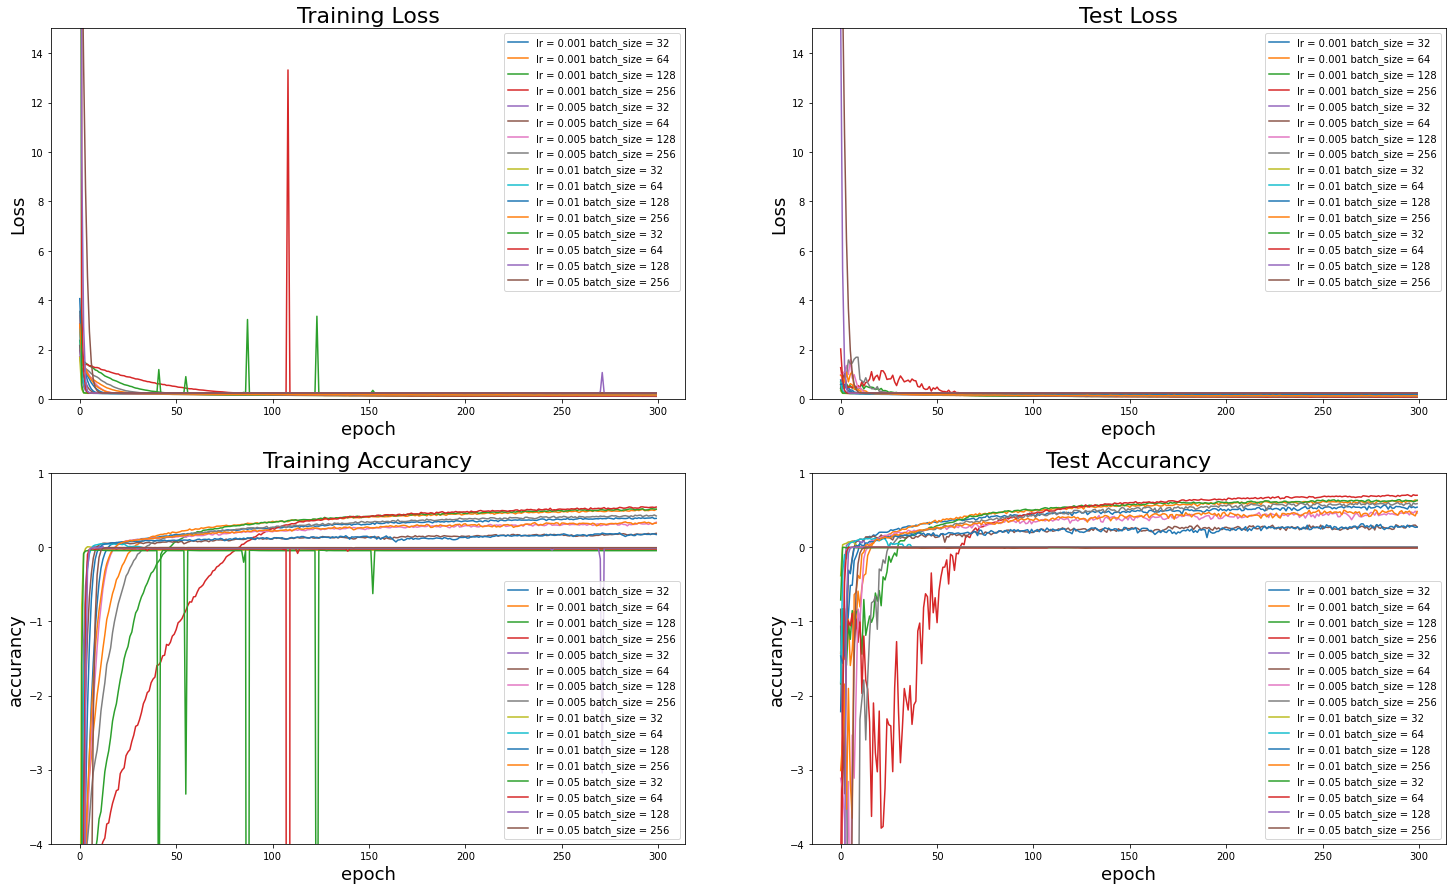

<Figure size 1800x1080 with 0 Axes>

In [14]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Training Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 15])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 15])

ax3.set_title("Training Accurancy", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-4,1])

ax4.set_title("Test Accurancy", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-4,1])

plt.show()

In [15]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.3899685766451747
0.5107461875851573
0.5142715508440333
0.5430536007103886
-0.03671201922353159
0.18801758967230103
0.3380792708261153
0.4230515103971337
-0.03755755536297762
-0.01685525471368933
0.1719938332514569
0.3267748138700771
-0.045468498042863535
-0.022443806852852327
-0.01262602878973411
-0.0050622282507266575
___________________

0.5416349212802918
0.6281373326960153
0.6352639551233741
0.7018206921706609
-0.0003864127810051521
0.2756036158299646
0.4617033508858457
0.5885411242368539
-0.0013850077837318509
-0.00045783312907166085
0.27224230302997543
0.4840838654120547
-0.004948456679091828
-0.008188831518028516
-0.0006803680831606318
-0.002604827113871444
___________________

0.13423418500019688
0.11147593015518326
0.11391081450841366
0.10926814167163311
0.24287717065880043
0.19102215537658104
0.15745193138718605
0.1385219778196934
0.24311755041488675
0.24286082678307325
0.19754969405058104
0.16140941091072866
0.2446411113893048
0.24405953278526282
0.24359842599966589
0.2429

### 2 best models

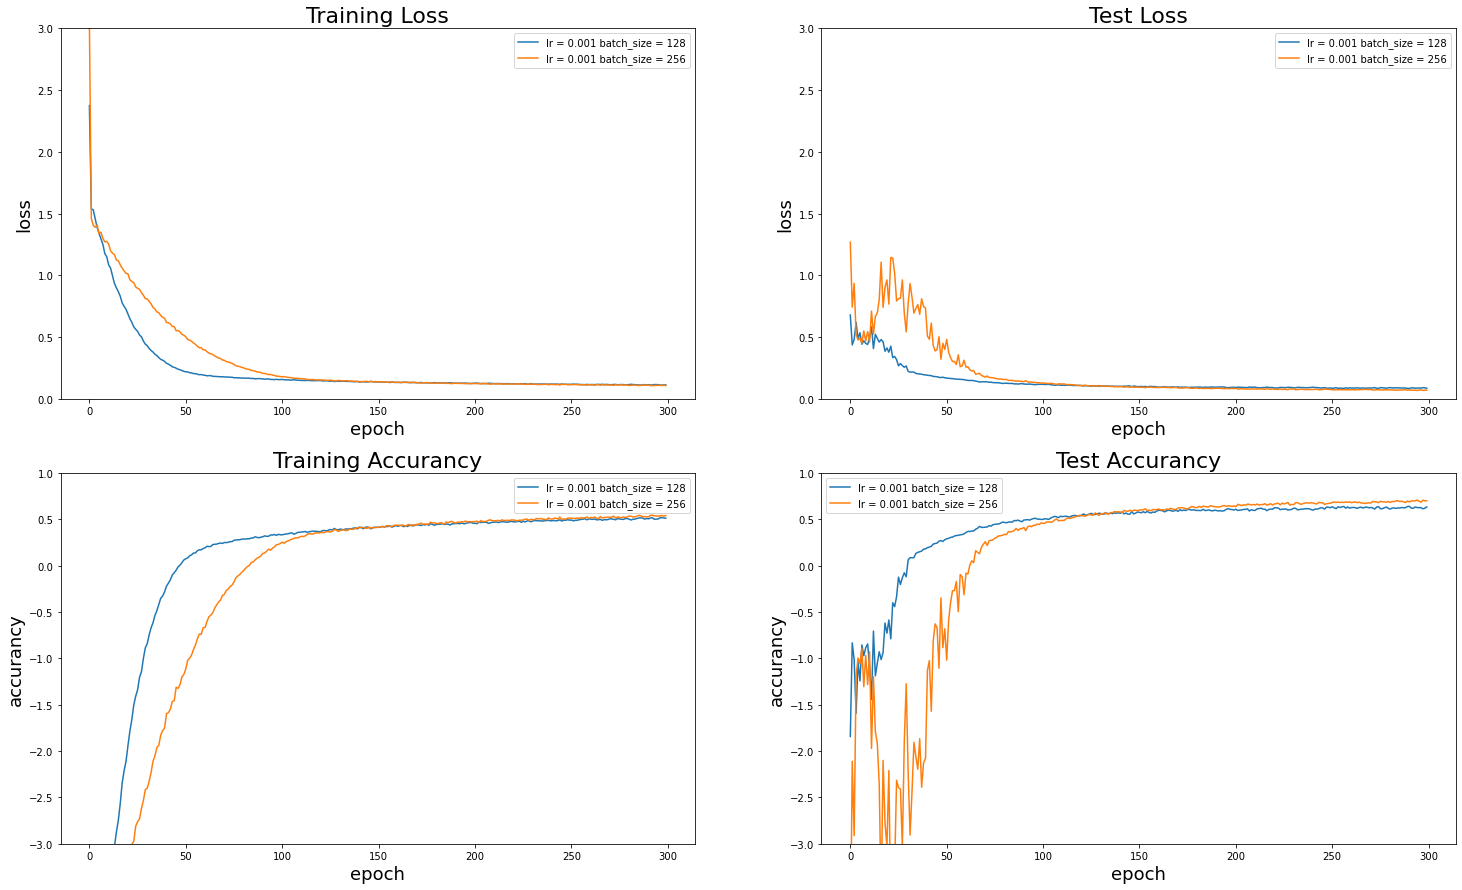

<Figure size 432x288 with 0 Axes>

In [20]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Training Loss", fontsize=22)
ax1.plot(train_losses_all[2],label="lr = 0.001 batch_size = 128")
ax1.plot(train_losses_all[3],label="lr = 0.001 batch_size = 256")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 3])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[2],label="lr = 0.001 batch_size = 128")
ax2.plot(test_losses_all[3],label="lr = 0.001 batch_size = 256")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 3])

ax3.set_title("Training Accurancy", fontsize=22)
ax3.plot(train_accs_all[2],label="lr = 0.001 batch_size = 128")
ax3.plot(train_accs_all[3],label="lr = 0.001 batch_size = 256")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-3,1])

ax4.set_title("Test Accurancy", fontsize=22)
ax4.plot(test_accs_all[2],label="lr = 0.001 batch_size = 128")
ax4.plot(test_accs_all[3],label="lr = 0.001 batch_size = 256")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-3,1])
plt.show()

## 4.2. Training

In [24]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=4984, shuffle=False)

In [25]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/geno_maccs_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 2.3171303081206784, Accuracy: -8.767954407825536
Test Avg. loss: 1.4209496974945068, Accuracy: -5.148967087270942
################## EPOCH 2 ##################
Train Avg. loss: 1.5087718550975506, Accuracy: -5.527633806660027
Test Avg. loss: 0.7163055539131165, Accuracy: -2.09971500400158
################## EPOCH 3 ##################
Train Avg. loss: 1.452624690074187, Accuracy: -5.279690731858384
Test Avg. loss: 0.7063375115394592, Accuracy: -2.0565796328232184
################## EPOCH 4 ##################
Train Avg. loss: 1.3919290628952858, Accuracy: -5.001686971859226
Test Avg. loss: 0.6386444568634033, Accuracy: -1.7636471522522537
################## EPOCH 5 ##################
Train Avg. loss: 1.3247039860639818, Accuracy: -4.729578119569492
Test Avg. loss: 0.5114507675170898, Accuracy: -1.2132338971694918
################## EPOCH 6 ##################
Train Avg. loss: 1.2983116893432078, Accuracy: -4.58695801611478
Tes

Train Avg. loss: 0.24077503115702897, Accuracy: -0.006698188374446066
Test Avg. loss: 0.20055875182151794, Accuracy: 0.13210919427391254
################## EPOCH 48 ##################
Train Avg. loss: 0.2361535261838864, Accuracy: 0.01104284487537914
Test Avg. loss: 0.20063291490077972, Accuracy: 0.13178826571658142
################## EPOCH 49 ##################
Train Avg. loss: 0.2308875585022645, Accuracy: 0.03183464122851681
Test Avg. loss: 0.20186597108840942, Accuracy: 0.12645241916669958
################## EPOCH 50 ##################
Train Avg. loss: 0.22515740961982653, Accuracy: 0.054147384103231846
Test Avg. loss: 0.20172303915023804, Accuracy: 0.12707087919301707
################## EPOCH 51 ##################
Train Avg. loss: 0.22068477068574, Accuracy: 0.07478726259642703
Test Avg. loss: 0.19932419061660767, Accuracy: 0.1374516088851212
################## EPOCH 52 ##################
Train Avg. loss: 0.21770903057394883, Accuracy: 0.08982379698016658
Test Avg. loss: 0.1985818

Train Avg. loss: 0.15934560462259328, Accuracy: 0.3301556751133245
Test Avg. loss: 0.1933605819940567, Accuracy: 0.16325833096540043
################## EPOCH 94 ##################
Train Avg. loss: 0.15730789265571496, Accuracy: 0.3387199655950322
Test Avg. loss: 0.19583775103092194, Accuracy: 0.1525386510275213
################## EPOCH 95 ##################
Train Avg. loss: 0.15760133276956204, Accuracy: 0.3372505436649771
Test Avg. loss: 0.19230704009532928, Accuracy: 0.1678174161995094
################## EPOCH 96 ##################
Train Avg. loss: 0.1562582439241501, Accuracy: 0.3403404812947085
Test Avg. loss: 0.19593894481658936, Accuracy: 0.1521008636205169
################## EPOCH 97 ##################
Train Avg. loss: 0.155229568720246, Accuracy: 0.34487291471243425
Test Avg. loss: 0.1938832849264145, Accuracy: 0.1609963973431604
################## EPOCH 98 ##################
Train Avg. loss: 0.15609910864478502, Accuracy: 0.3419181173124377
Test Avg. loss: 0.19764980673789978,

Train Avg. loss: 0.13980649765103292, Accuracy: 0.4090188173086351
Test Avg. loss: 0.20178693532943726, Accuracy: 0.12679444862921885
################## EPOCH 140 ##################
Train Avg. loss: 0.13980489443892088, Accuracy: 0.40951935500854336
Test Avg. loss: 0.20136339962482452, Accuracy: 0.12862718084694746
################## EPOCH 141 ##################
Train Avg. loss: 0.1400584852657257, Accuracy: 0.40723970213338045
Test Avg. loss: 0.20239348709583282, Accuracy: 0.12416967969959014
################## EPOCH 142 ##################
Train Avg. loss: 0.139566829523597, Accuracy: 0.4118223140322252
Test Avg. loss: 0.20136821269989014, Accuracy: 0.12860642801390354
################## EPOCH 143 ##################
Train Avg. loss: 0.13848873414099216, Accuracy: 0.41568383992826613
Test Avg. loss: 0.1986420750617981, Accuracy: 0.14040339430444648
################## EPOCH 144 ##################
Train Avg. loss: 0.1399002460619578, Accuracy: 0.40612291961711644
Test Avg. loss: 0.198567

Train Avg. loss: 0.12760724456837544, Accuracy: 0.4563967145256849
Test Avg. loss: 0.19878286123275757, Accuracy: 0.13979416720704108
################## EPOCH 186 ##################
Train Avg. loss: 0.12816014016668, Accuracy: 0.45597693095771163
Test Avg. loss: 0.20778879523277283, Accuracy: 0.10082214592061489
################## EPOCH 187 ##################
Train Avg. loss: 0.13156275732968098, Accuracy: 0.443729290507563
Test Avg. loss: 0.20170800387859344, Accuracy: 0.12713599020117006
################## EPOCH 188 ##################
Train Avg. loss: 0.12651816063011304, Accuracy: 0.46340234103239497
Test Avg. loss: 0.20263618230819702, Accuracy: 0.12311938307429493
################## EPOCH 189 ##################
Train Avg. loss: 0.13074637304704922, Accuracy: 0.44300582620708856
Test Avg. loss: 0.20949594676494598, Accuracy: 0.093434675729135
################## EPOCH 190 ##################
Train Avg. loss: 0.12724381174223545, Accuracy: 0.46067664831723665
Test Avg. loss: 0.2000433

Train Avg. loss: 0.11827851182375199, Accuracy: 0.4977194814535738
Test Avg. loss: 0.2072337567806244, Accuracy: 0.10322406251215643
################## EPOCH 232 ##################
Train Avg. loss: 0.11682220748983897, Accuracy: 0.5022763596030774
Test Avg. loss: 0.20268793404102325, Accuracy: 0.12289550740356436
################## EPOCH 233 ##################
Train Avg. loss: 0.117379071095433, Accuracy: 0.5009893079282514
Test Avg. loss: 0.20034192502498627, Accuracy: 0.13304749713851516
################## EPOCH 234 ##################
Train Avg. loss: 0.11821820496175534, Accuracy: 0.4975065335890522
Test Avg. loss: 0.20864339172840118, Accuracy: 0.09712394312040429
################## EPOCH 235 ##################
Train Avg. loss: 0.12018668035475108, Accuracy: 0.4889819166088535
Test Avg. loss: 0.1995471715927124, Accuracy: 0.13648665494564838
################## EPOCH 236 ##################
Train Avg. loss: 0.12157281712652782, Accuracy: 0.4838780078903193
Test Avg. loss: 0.199744403

Train Avg. loss: 0.11506034066088688, Accuracy: 0.5141528867694963
Test Avg. loss: 0.2053849697113037, Accuracy: 0.1112244317540717
################## EPOCH 278 ##################
Train Avg. loss: 0.1121302880346775, Accuracy: 0.5217627401660062
Test Avg. loss: 0.20489315688610077, Accuracy: 0.1133526309249685
################## EPOCH 279 ##################
Train Avg. loss: 0.11394462605508474, Accuracy: 0.5141928922616508
Test Avg. loss: 0.2075415551662445, Accuracy: 0.10189204655295847
################## EPOCH 280 ##################
Train Avg. loss: 0.11606966006832245, Accuracy: 0.5093123624034307
Test Avg. loss: 0.20407024025917053, Accuracy: 0.1169137488232912
################## EPOCH 281 ##################
Train Avg. loss: 0.11289825768042834, Accuracy: 0.5189338177042481
Test Avg. loss: 0.20250268280506134, Accuracy: 0.12369713011345185
################## EPOCH 282 ##################
Train Avg. loss: 0.11463260402282079, Accuracy: 0.51136469932592
Test Avg. loss: 0.2016669660806

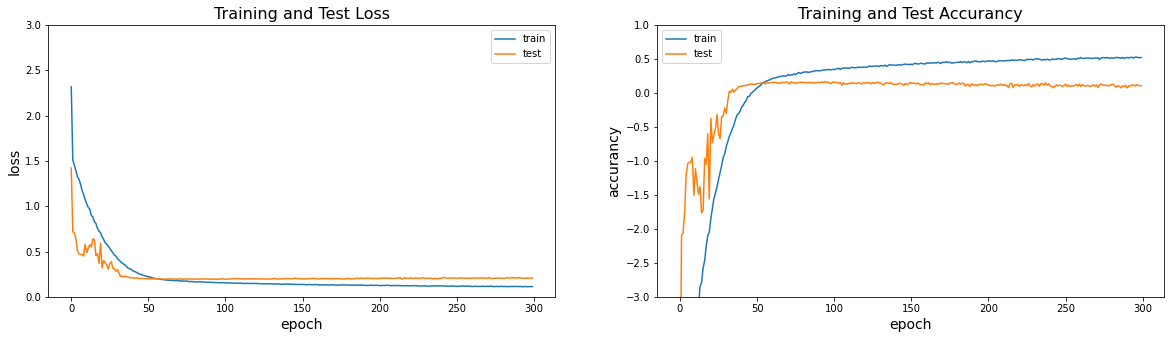

<Figure size 1440x360 with 0 Axes>

In [27]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Training and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.set_ylim([0,3])
ax1.legend()

ax2.set_title("Training and Test Accurancy", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("accurancy", fontsize=14)
ax2.set_ylim([-3,1])
ax2.legend()
plt.show()

In [28]:
model = FCNN()
model.load_state_dict(torch.load('../../models/geno_maccs_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.31714645
MSE: 0.19230703
RMSE: 0.43852824
R2 Square 0.1678174161995094 

